### Simple Machine Learning Clustering of Devices 

#### Imports

In [1]:
import os
import json
import pandas as pd
import numpy as np

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance


from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import VarianceThreshold



import matplotlib.pyplot as plt
import seaborn as sns

from imagehat.identifiers.exif_attribute_information import EXIF_TAG_DICT_REV, GPS_TAG_DICT_REV, INTEROP_TAG_DICT_REV

### Retrieving Dresden and DivNoise Datasets


In [2]:
def get_data(fp):
    with open(fp, "r") as f:
        json_dataset = json.load(f)

        return {k.split("\\")[-1]: v for k, v in json_dataset.items()}

In [3]:
dresden_folder = os.path.join("datasets", "json_datasets", "dresden_images", "dresden_metadata_full.json") 

dresden_data = get_data(dresden_folder)
print("Confirming import:", len(dresden_data))

Confirming import: 16961


In [4]:
# Only utilized when full dataset is not present

# def get_divnoise(fp):
#     data = {}
#     # full_path = os.path.join(fp, path)
#     for files in os.listdir(fp):
#         full_fn = os.path.join(fp, files)
#         with open(full_fn, "r") as f: 
#             json_data = json.load(f)
#             data.update({k.split("\\")[-1]: v for k, v in json_data.items()})
#     return data



#  divnoise_location = r"D:\image_dataset\Metadata\DivNoise_metadata"
# divnoise_data = {}


# for paths in os.listdir(divnoise_location):
#     meta_loc = os.path.join(divnoise_location, paths)
#     for meta in os.listdir(meta_loc):
#         file_name = os.path.join(meta_loc, meta)
#         with open(file_name, "r") as file:
#             data = json.load(file)
#         divnoise_data.update(data)

In [5]:
# divnoise_folder = r"datasets\json_datasets\divnoise_images\divnoise_metadata_full_wm.json"
divnoise_folder = os.path.join("datasets", "json_datasets", "divnoise_images", "divnoise_dataset_full.json")

divnoise_data = get_data(divnoise_folder)

print("Confirming import:", len(divnoise_data))

# NOTE Divnoise is supposed to have 15,000 images plus according to https://divnoise.fotoverifier.eu/
# but there seems to be a deviation.

Confirming import: 15017


In [6]:
# # Only use this if you wish to save the data in a new file
# save_path = r"D:\image_dataset\Metadata\DivNoise_metadata"

# output_file = os.path.join(save_path, "divnoise_metadata_full.json")


# with open(output_file, "w", encoding="utf-8") as out_file:
#     json.dump(divnoise_data, out_file, indent=4)

    

In [7]:
# Counting .jpg/.jpeg occurences in the nested folder of divnoise to ensure all data is included

divnoise_image_loc = r"D:\image_dataset\Images\Divnoise_image_dataset"

def count_jpeg_files(root_path):
    jpeg_count = 0
    for dirpath, _, filenames in os.walk(root_path):
        for filename in filenames:
            if filename.lower().endswith(('.jpg', '.jpeg')):
                jpeg_count += 1
    return jpeg_count


count = count_jpeg_files(divnoise_image_loc)
print(f"\nTotal JPEG files found under '{divnoise_image_loc}': {count}")
# Correct output


Total JPEG files found under 'D:\image_dataset\Images\Divnoise_image_dataset': 0


## Inspecting the Datasets

## Dresden Dataset

In [8]:
# LAST two parts removed (_0_48387.JPG). Still a label too much after this cleansing. 
device_names = []

for file_name in dresden_data.keys():

    file_name = file_name.replace('.JPG', '').replace('.jpg', '')
    
    parts = file_name.split('_')
    
    device_name = '_'.join(parts[:-2])
    
    device_names.append(device_name)

unique_devices = set(device_names)
device_count = len(unique_devices)

print("Extracted Device Names (Dresden):", sorted(unique_devices))
print("Number of Unique Devices (Dresden):", device_count, "(This will be mitigated. Nikon D70s is to be removed)")
print("Number of Unique Images (Dresden):", len(dresden_data.keys()))


Extracted Device Names (Dresden): ['Agfa_DC-504', 'Agfa_DC-733s', 'Agfa_DC-830i', 'Agfa_Sensor505-x', 'Agfa_Sensor530s', 'Canon_Ixus55', 'Canon_Ixus70', 'Canon_PowerShotA640', 'Casio_EX-Z150', 'FujiFilm_FinePixJ50', 'Kodak_M1063', 'Nikon_CoolPixS710', 'Nikon_D200', 'Nikon_D70', 'Nikon_D70s', 'Olympus_mju_1050SW', 'Panasonic_DMC-FZ50', 'Pentax_OptioA40', 'Pentax_OptioW60', 'Praktica_DCZ5.9', 'Ricoh_GX100', 'Rollei_RCP-7325XS', 'Samsung_L74wide', 'Samsung_NV15', 'Sony_DSC-H50', 'Sony_DSC-T77', 'Sony_DSC-W170']
Number of Unique Devices (Dresden): 27 (This will be mitigated. Nikon D70s is to be removed)
Number of Unique Images (Dresden): 16961


In [9]:
list_images_dresden = dresden_data.keys()
images_per_device = {}

def remove_extension(filename):
    no_ext = os.path.splitext(filename)[0]
    return no_ext.rsplit('_', 1)[0]           


device_feature = list(map(remove_extension, list_images_dresden))
unique_devices = set(device_feature)
print("Unique Devices (Dresden):", len(unique_devices))
print("Unique Devices (Dresden):", sorted(unique_devices))


Unique Devices (Dresden): 74
Unique Devices (Dresden): ['Agfa_DC-504_0', 'Agfa_DC-733s_0', 'Agfa_DC-830i_0', 'Agfa_Sensor505-x_0', 'Agfa_Sensor530s_0', 'Canon_Ixus55_0', 'Canon_Ixus70_0', 'Canon_Ixus70_1', 'Canon_Ixus70_2', 'Canon_PowerShotA640_0', 'Casio_EX-Z150_0', 'Casio_EX-Z150_1', 'Casio_EX-Z150_2', 'Casio_EX-Z150_3', 'Casio_EX-Z150_4', 'FujiFilm_FinePixJ50_0', 'FujiFilm_FinePixJ50_1', 'FujiFilm_FinePixJ50_2', 'Kodak_M1063_0', 'Kodak_M1063_1', 'Kodak_M1063_2', 'Kodak_M1063_3', 'Kodak_M1063_4', 'Nikon_CoolPixS710_0', 'Nikon_CoolPixS710_1', 'Nikon_CoolPixS710_2', 'Nikon_CoolPixS710_3', 'Nikon_CoolPixS710_4', 'Nikon_D200_0', 'Nikon_D200_1', 'Nikon_D70_0', 'Nikon_D70_1', 'Nikon_D70s_0', 'Nikon_D70s_1', 'Olympus_mju_1050SW_0', 'Olympus_mju_1050SW_1', 'Olympus_mju_1050SW_2', 'Olympus_mju_1050SW_3', 'Olympus_mju_1050SW_4', 'Panasonic_DMC-FZ50_0', 'Panasonic_DMC-FZ50_1', 'Panasonic_DMC-FZ50_2', 'Pentax_OptioA40_0', 'Pentax_OptioA40_1', 'Pentax_OptioA40_2', 'Pentax_OptioA40_3', 'Pentax_Opt

['Ricoh', 'Nikon', 'Olympus', 'Agfa', 'Canon', 'Casio', 'Kodak', 'Praktica', 'Samsung', 'Samsung', 'Panasonic', 'Praktica', 'Casio', 'Casio', 'Kodak', 'Pentax', 'Agfa', 'Ricoh', 'Sony', 'Sony', 'Agfa', 'Canon', 'Praktica', 'Ricoh', 'FujiFilm', 'Sony', 'Sony', 'Rollei', 'Kodak', 'Sony', 'Panasonic', 'Olympus', 'Samsung', 'Pentax', 'Nikon', 'Nikon', 'FujiFilm', 'Canon', 'Rollei', 'Nikon', 'Casio', 'Casio', 'Nikon', 'Kodak', 'Olympus', 'Nikon', 'Samsung', 'Pentax', 'Praktica', 'Nikon', 'Olympus', 'Ricoh', 'Pentax', 'Sony', 'Nikon', 'Ricoh', 'Praktica', 'Canon', 'Samsung', 'Sony', 'Nikon', 'Canon', 'Kodak', 'FujiFilm', 'Sony', 'Pentax', 'Olympus', 'Agfa', 'Panasonic', 'Samsung', 'Nikon', 'Agfa', 'Nikon', 'Rollei']


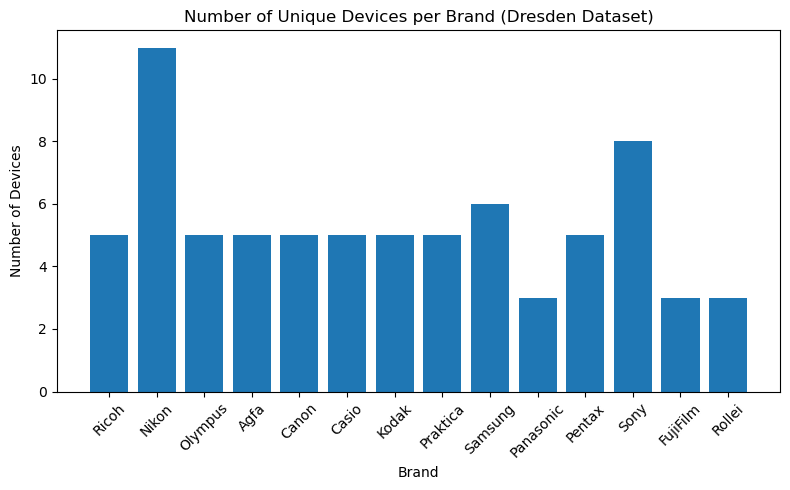

In [10]:
brands_divnoise = [model.split('_')[0] for model in unique_devices]
print(brands_divnoise)

brand_counts = Counter(brands_divnoise)

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(brand_counts.keys(), brand_counts.values())
plt.xticks(rotation=45)
plt.xlabel("Brand")
plt.ylabel("Number of Devices")
plt.title("Number of Unique Devices per Brand (Dresden Dataset)")
plt.tight_layout()
plt.show()

## Divnoise Dataset

In [11]:
device_names_divnoise = []

for file_name in divnoise_data.keys():

    file_name = file_name.replace('.JPG', '').replace('.jpg', '')

    file_name = file_name.split("\\")[-1]

    parts = file_name.split('_')

    device_name = '_'.join(parts[:-2])  
    
    device_names_divnoise.append(device_name)

unique_devices_divnoise = set(device_names_divnoise)
device_count_divnoise = len(unique_devices_divnoise)

print("Extracted Device Names (DivNoise):", sorted(unique_devices_divnoise))
print("Number of Individual Cameras (DivNoise):", device_count_divnoise) # We will drop 
print("Number of Unique Images (DivNoise):", len(divnoise_data.keys()))


Extracted Device Names (DivNoise): ['Acer_AspireE5_Frontal_0', 'Apple_MacBookAir2018_Frontal_0', 'Apple_iMac27inch2012_Frontal_0', 'Apple_iMac27inch2013_Frontal_0', 'Apple_iPadmini5_Frontal_0', 'Apple_iPadmini5_Rear_0', 'Apple_iPhone13_Frontal_0', 'Apple_iPhone13_Rear_0', 'Canon_EOS6DMarkII_Rear_0', 'Canon_EOS6DMarkII_Rear_1', 'Canon_EOS6DMarkII_Rear_2', 'Canon_EOS6DMarkII_Rear_3', 'Canon_EOS6DMarkII_Rear_4', 'Canon_EOS6DMarkII_Rear_5', 'Canon_EOS6DMarkII_Rear_6', 'Canon_EOS6D_Rear_0', 'Canon_EOS6D_Rear_1', 'Canon_EOS6D_Rear_2', 'Canon_EOSR_Rear_0', 'Canon_EOSR_Rear_1', 'Canon_EOSR_Rear_2', 'Canon_EOSR_Rear_3', 'Canon_EOSR_Rear_4', 'Canon_EOSR_Rear_5', 'Canon_EOSR_Rear_6', 'Canon_EOSR_Rear_7', 'Huawei_P20Lite_Frontal_0', 'Huawei_P20Lite_Rear_0', 'Logitech_C920_Frontal_0', 'Motorola_MotoG6Play_Frontal_0', 'Motorola_MotoG6Play_Rear_0', 'Samsung_GalaxyA71_Frontal_0', 'Samsung_GalaxyA71_Rear_0', 'Samsung_GalaxyTabA_Frontal_0', 'Samsung_GalaxyTabA_Rear_0', 'Samsung_GalaxyTabS5e_Frontal_0', 

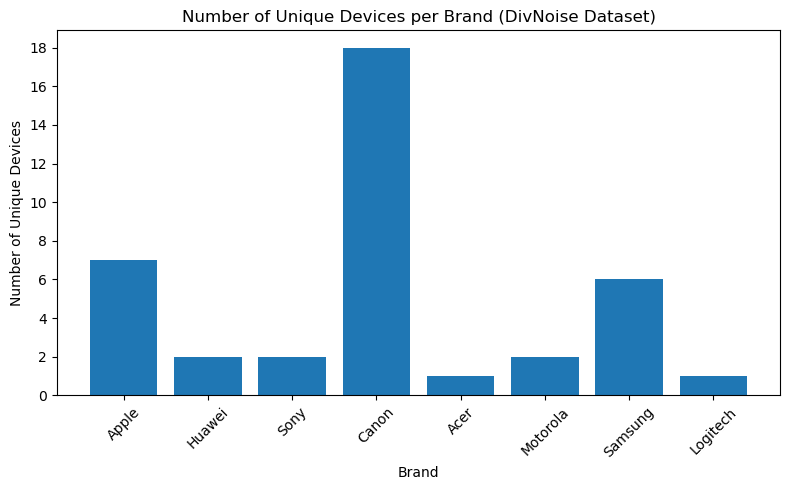

In [12]:

brands_divnoise = [model.split('_')[0] for model in unique_devices_divnoise]
brand_counts_divnoise = Counter(brands_divnoise)

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(brand_counts_divnoise.keys(), brand_counts_divnoise.values())
plt.yticks(range(0, max(brand_counts_divnoise.values())+2, 2))
plt.xticks(rotation=45)
plt.xlabel("Brand")
plt.ylabel("Number of Unique Devices")
plt.title("Number of Unique Devices per Brand (DivNoise Dataset)")
plt.tight_layout()
plt.show()


## Preprocessing Data

## General Preparing of Data

In [13]:
def get_baseline_tags(tag_dict) -> list:
    sorted_keys = sorted(tag_dict.keys(), key=lambda x: int.from_bytes(x, 'big'))
    tag_names = [tag_dict[k] for k in sorted_keys]
    dec_values = [int.from_bytes(k, 'big') for k in sorted_keys]
    return dec_values, tag_names

In [14]:
exif_values, exif_baseline = get_baseline_tags(EXIF_TAG_DICT_REV)
gps_values, gps_baseline = get_baseline_tags(GPS_TAG_DICT_REV)
interop_values, interop_baseline = get_baseline_tags(INTEROP_TAG_DICT_REV)


In [15]:
print("EXIF Baseline:", exif_baseline)
print("GPS Baseline:", gps_baseline) 
print("Interop Baseline:", interop_baseline)

EXIF Baseline: ['ExposureTime', 'FNumber', 'ExposureProgram', 'SpectralSensitivity', 'PhotographicSensitivity', 'OECF', 'SensitivityType', 'StandardOutputSensitivity', 'RecommendedExposureIndex', 'ISOSpeed', 'ISOSpeedLatitudeyyy', 'ISOSpeedLatitudezzz', 'ExifVersion', 'DateTimeOriginal', 'DateTimeDigitized', 'OffsetTime', 'OffsetTimeOriginal', 'OffsetTimeDigitized', 'ComponentsConfiguration', 'CompressedBitsPerPixel', 'ShutterSpeedValue', 'ApertureValue', 'BrightnessValue', 'ExposureBiasValue', 'MaxApertureValue', 'SubjectDistance', 'MeteringMode', 'LightSource', 'Flash', 'FocalLength', 'SubjectArea', 'MakerNote', 'UserComment', 'SubSecTime', 'SubSecTimeOriginal', 'SubSecTimeDigitized', 'Temperature', 'Humidity', 'Pressure', 'WaterDepth', 'Acceleration', 'CameraElevationAngle', 'FlashpixVersion', 'ColorSpace', 'PixelXDimension', 'PixelYDimension', 'RelatedSoundFile', 'InteroperabilityIFDPointer', 'FlashEnergy', 'SpatialFrequencyResponse', 'FocalPlaneXResolution', 'FocalPlaneYResolution

In [16]:
print("Verify Ascending Order:")
print("EXIF baseline:", exif_baseline)
print("EXIF values:", exif_values)
print("GPS values:", gps_values)
print("Interop values:", interop_values)

Verify Ascending Order:
EXIF baseline: ['ExposureTime', 'FNumber', 'ExposureProgram', 'SpectralSensitivity', 'PhotographicSensitivity', 'OECF', 'SensitivityType', 'StandardOutputSensitivity', 'RecommendedExposureIndex', 'ISOSpeed', 'ISOSpeedLatitudeyyy', 'ISOSpeedLatitudezzz', 'ExifVersion', 'DateTimeOriginal', 'DateTimeDigitized', 'OffsetTime', 'OffsetTimeOriginal', 'OffsetTimeDigitized', 'ComponentsConfiguration', 'CompressedBitsPerPixel', 'ShutterSpeedValue', 'ApertureValue', 'BrightnessValue', 'ExposureBiasValue', 'MaxApertureValue', 'SubjectDistance', 'MeteringMode', 'LightSource', 'Flash', 'FocalLength', 'SubjectArea', 'MakerNote', 'UserComment', 'SubSecTime', 'SubSecTimeOriginal', 'SubSecTimeDigitized', 'Temperature', 'Humidity', 'Pressure', 'WaterDepth', 'Acceleration', 'CameraElevationAngle', 'FlashpixVersion', 'ColorSpace', 'PixelXDimension', 'PixelYDimension', 'RelatedSoundFile', 'InteroperabilityIFDPointer', 'FlashEnergy', 'SpatialFrequencyResponse', 'FocalPlaneXResolution'

In [17]:
print("Control Sizes for feature extraction:")
print("EXIF sizes", len(exif_values))
print("GPS sizes", len(gps_values))
print("Interop sizes", len(interop_values))
print("Feature sizes", len(exif_values)+len(gps_values)+len(interop_values))


Control Sizes for feature extraction:
EXIF sizes 89
GPS sizes 32
Interop sizes 5
Feature sizes 126


## Creating a DataFrame

In [18]:
combined_json = {**dresden_data, **divnoise_data}

In [19]:
len(combined_json)

31978

In [20]:
# Creating a reference table
combined_images = list(dresden_data.keys()) + list(divnoise_data.keys())

reference_df = pd.DataFrame({
    "id": range(0, len(combined_images)),
    "image": combined_images,
})
print(len(reference_df))
reference_df.head()
reference_df.tail()

31978


id                                image
31973  31973  Canon_EOS6DMarkII_Rear_6_Nat_95.jpg
31974  31974  Canon_EOS6DMarkII_Rear_6_Nat_96.jpg
31975  31975  Canon_EOS6DMarkII_Rear_6_Nat_97.jpg
31976  31976  Canon_EOS6DMarkII_Rear_6_Nat_98.jpg
31977  31977  Canon_EOS6DMarkII_Rear_6_Nat_99.jpg

In [21]:
def extract_device_names(dataset, end):
    device_names = []
    for file_name in dataset.keys():
        file_name = file_name.replace(".JPG", "").replace(".jpg", "")
        parts = file_name.split("_")
        device_name = "_".join(parts[:-end])

        if device_name.startswith("Nikon_D70s"):
            device_name = device_name.replace("Nikon_D70s", "Nikon_D70")

        device_names.append(device_name)
    return device_names



In [22]:
dresden_image_names = extract_device_names(dresden_data, 2)
divnoise_image_names = extract_device_names(divnoise_data, 3)

dresden_models = set(dresden_image_names)
divnoise_models = set(divnoise_image_names)

# Show unique sets
print("Dresden DSC models: ", dresden_models)
print("DivNoise DSC models: ", sorted(divnoise_models))

print("Unique DSC models in Dresden: ", len(dresden_models))
print("Unique DSC models in DivNoise: ", len(divnoise_models))

print("All images of Dresden:", len(dresden_image_names))
print("All images of Divnoise:", len(divnoise_image_names))

Dresden DSC models:  {'Praktica_DCZ5.9', 'Sony_DSC-W170', 'Samsung_NV15', 'Sony_DSC-T77', 'Canon_PowerShotA640', 'Pentax_OptioA40', 'Agfa_DC-830i', 'Nikon_D70', 'Agfa_Sensor530s', 'Kodak_M1063', 'Pentax_OptioW60', 'Rollei_RCP-7325XS', 'Olympus_mju_1050SW', 'Sony_DSC-H50', 'Nikon_CoolPixS710', 'Nikon_D200', 'Agfa_Sensor505-x', 'FujiFilm_FinePixJ50', 'Casio_EX-Z150', 'Ricoh_GX100', 'Samsung_L74wide', 'Agfa_DC-504', 'Panasonic_DMC-FZ50', 'Canon_Ixus70', 'Agfa_DC-733s', 'Canon_Ixus55'}
DivNoise DSC models:  ['Acer_AspireE5_Frontal', 'Apple_MacBookAir2018_Frontal', 'Apple_iMac27inch2012_Frontal', 'Apple_iMac27inch2013_Frontal', 'Apple_iPadmini5_Frontal', 'Apple_iPadmini5_Rear', 'Apple_iPhone13_Frontal', 'Apple_iPhone13_Rear', 'Canon_EOS6DMarkII_Rear', 'Canon_EOS6D_Rear', 'Canon_EOSR_Rear', 'Huawei_P20Lite_Frontal', 'Huawei_P20Lite_Rear', 'Logitech_C920_Frontal', 'Motorola_MotoG6Play_Frontal', 'Motorola_MotoG6Play_Rear', 'Samsung_GalaxyA71_Frontal', 'Samsung_GalaxyA71_Rear', 'Samsung_GalaxyT

In [23]:
# Build individual DataFrames
df_dresden = pd.DataFrame({
    "image": list(dresden_data.keys()),     
    "device": dresden_image_names
})

df_divnoise = pd.DataFrame({
    "image": list(divnoise_data.keys()),
    "device": divnoise_image_names
})

# Combine both
df_all = pd.concat([df_dresden, df_divnoise], ignore_index=True)
df_all = df_all.merge(reference_df, on="image", how="left")


# Preview
print("Combined dataset created.")
print(df_all.head(), end="\n\n")
print(df_all.tail())

Combined dataset created.
                  image       device  id
0   Agfa_DC-504_0_1.JPG  Agfa_DC-504   0
1  Agfa_DC-504_0_10.JPG  Agfa_DC-504   1
2  Agfa_DC-504_0_11.JPG  Agfa_DC-504   2
3  Agfa_DC-504_0_12.JPG  Agfa_DC-504   3
4  Agfa_DC-504_0_13.JPG  Agfa_DC-504   4

                                     image                  device     id
31973  Canon_EOS6DMarkII_Rear_6_Nat_95.jpg  Canon_EOS6DMarkII_Rear  31973
31974  Canon_EOS6DMarkII_Rear_6_Nat_96.jpg  Canon_EOS6DMarkII_Rear  31974
31975  Canon_EOS6DMarkII_Rear_6_Nat_97.jpg  Canon_EOS6DMarkII_Rear  31975
31976  Canon_EOS6DMarkII_Rear_6_Nat_98.jpg  Canon_EOS6DMarkII_Rear  31976
31977  Canon_EOS6DMarkII_Rear_6_Nat_99.jpg  Canon_EOS6DMarkII_Rear  31977


In [24]:
df_dresden["image"].head()

0     Agfa_DC-504_0_1.JPG
1    Agfa_DC-504_0_10.JPG
2    Agfa_DC-504_0_11.JPG
3    Agfa_DC-504_0_12.JPG
4    Agfa_DC-504_0_13.JPG
Name: image, dtype: object

In [25]:
df_divnoise["image"].head()

0    Canon_EOS6D_Rear_0_Flat_32.jpg
1    Canon_EOS6D_Rear_0_Flat_25.jpg
2    Canon_EOS6D_Rear_0_Flat_44.jpg
3    Canon_EOS6D_Rear_0_Flat_12.jpg
4    Canon_EOS6D_Rear_0_Flat_15.jpg
Name: image, dtype: object

In [26]:
df_all.isna().sum()

image     0
device    0
id        0
dtype: int64

In [27]:
# Categorical features
exif_df = pd.DataFrame(columns=exif_baseline)
gps_df = pd.DataFrame(columns=gps_baseline)
interop_df = pd.DataFrame(columns=interop_baseline)


In [28]:
print("Rows and Cols: ", df_all.shape)

Rows and Cols:  (31978, 3)


## Dealing with expected tag pos + Preparing df

In [29]:
# Records the expected psoiton for each tag in the baseline

exif_baseline_position = {tag: idx for idx, tag in enumerate(exif_baseline)}
gps_baseline_position = {tag: idx for idx, tag in enumerate(gps_baseline)}
interop_baseline_position = {tag: idx for idx, tag in enumerate(interop_baseline)}

exif_baseline_position


{'ExposureTime': 0,
 'FNumber': 1,
 'ExposureProgram': 2,
 'SpectralSensitivity': 3,
 'PhotographicSensitivity': 4,
 'OECF': 5,
 'SensitivityType': 6,
 'StandardOutputSensitivity': 7,
 'RecommendedExposureIndex': 8,
 'ISOSpeed': 9,
 'ISOSpeedLatitudeyyy': 10,
 'ISOSpeedLatitudezzz': 11,
 'ExifVersion': 12,
 'DateTimeOriginal': 13,
 'DateTimeDigitized': 14,
 'OffsetTime': 15,
 'OffsetTimeOriginal': 16,
 'OffsetTimeDigitized': 17,
 'ComponentsConfiguration': 18,
 'CompressedBitsPerPixel': 19,
 'ShutterSpeedValue': 20,
 'ApertureValue': 21,
 'BrightnessValue': 22,
 'ExposureBiasValue': 23,
 'MaxApertureValue': 24,
 'SubjectDistance': 25,
 'MeteringMode': 26,
 'LightSource': 27,
 'Flash': 28,
 'FocalLength': 29,
 'SubjectArea': 30,
 'MakerNote': 31,
 'UserComment': 32,
 'SubSecTime': 33,
 'SubSecTimeOriginal': 34,
 'SubSecTimeDigitized': 35,
 'Temperature': 36,
 'Humidity': 37,
 'Pressure': 38,
 'WaterDepth': 39,
 'Acceleration': 40,
 'CameraElevationAngle': 41,
 'FlashpixVersion': 42,
 'C

In [30]:
# Records the observed tags (and the missing tags)

observed_exif, observed_gps, observed_interop, observed_metrics = [], [], [], []

temp = []
images = list(combined_json.keys())
for img in images:
    file_metadata = combined_json.get(img, {})
    app1_info = file_metadata.get("APP1 Info", {})

    exif_data = app1_info.get("EXIF IFD Data", {})
    gps_data = app1_info.get("GPS IFD Data", {})
    interop_data = app1_info.get("Interop IFD Data", {})

    metrics = file_metadata.get("Metrics", {})

    exif_order = {tag: exif_data[tag].get("IFD Tag Order", None) for tag in exif_data}
    gps_order = {tag: gps_data[tag].get("IFD Tag Order", None) for tag in gps_data}
    interop_order = {tag: interop_data[tag].get("IFD Tag Order", None) for tag in interop_data}

    metrics_per_image = {k: v for k, v in metrics.items()}

    observed_exif.append(exif_order)
    observed_gps.append(gps_order)
    observed_interop.append(interop_order)
    observed_metrics.append(metrics_per_image)

In [31]:
print(observed_exif[0])
print(observed_metrics)

print(len(observed_exif))
print(len(observed_metrics))


{'ExposureTime': 0, 'FNumber': 1, 'ExposureProgram': 2, 'PhotographicSensitivity': 3, 'ExifVersion': 4, 'DateTimeOriginal': 5, 'DateTimeDigitized': 6, 'ComponentsConfiguration': 7, 'CompressedBitsPerPixel': 8, 'ShutterSpeedValue': 9, 'ApertureValue': 10, 'ExposureBiasValue': 11, 'MaxApertureValue': 12, 'MeteringMode': 13, 'LightSource': 14, 'Flash': 15, 'FocalLength': 16, 'MakerNote': 17, 'FlashpixVersion': 18, 'ColorSpace': 19, 'PixelXDimension': 20, 'PixelYDimension': 21, 'InteroperabilityIFDPointer': 22, 'SensingMethod': 23, 'FileSource': 24, 'SceneType': 25, 'CFAPattern': 26, 'CustomRendered': 27, 'ExposureMode': 28, 'WhiteBalance': 29, 'SceneCaptureType': 30, 'Contrast': 31, 'Saturation': 32, 'Sharpness': 33, 'SubjectDistanceRange': 34, 'RelatedSoundFile': 35}
[{'Header VAL': 1.0, 'Tag VAL Score': 0.77632, 'Weak Tag Order Score': {'EXIF': 0.78464, 'Interop': 1.0}, 'Strict Tag Order Score': {'EXIF': 0.97937, 'Interop': 1.0}, 'EXIF Conformity Score': 0.84675}, {'Header VAL': 1.0, 'T

### Finding unknown tags

In [32]:

# Set to collect all unknown tags across images
all_unknown_tags = set()

# First pass: collect all unique unknown tags
for metadata in combined_json.values():
    for section in ["0th IFD Data", "EXIF IFD Data", "1st IFD Data", "Interop IFD Data"]:
        tags = metadata.get("APP1 Info", {}).get(section, {})
        unknowns = [tag for tag in tags if tag.startswith("Unknown_")]
        all_unknown_tags.update(unknowns)

all_unknown_tags = sorted(all_unknown_tags)



In [33]:
# Second pass builds DataFrame rows
rows = []

for image_name, metadata in combined_json.items():
    row = {"image": image_name}

    # Initialize all unknown tag features to 0
    for tag in all_unknown_tags:
        row[tag] = 0

    # Set features to 1 where unknown tags exist
    for section in ["0th IFD Data", "EXIF IFD Data", "1st IFD Data", "Interop IFD Data"]:
        tags = metadata.get("APP1 Info", {}).get(section, {})
        for tag in tags:
            if tag in all_unknown_tags:
                row[tag] = 1

    rows.append(row)

# Build final DataFrame
unknown_df = pd.DataFrame(rows)

In [34]:
print(unknown_df.head())
print(unknown_df.isna().sum())
print(len(unknown_df))

                  image  Unknown_b'GF'  Unknown_b'\x01<'  Unknown_b'\x01\r'  \
0   Agfa_DC-504_0_1.JPG              0                 0                  0   
1  Agfa_DC-504_0_10.JPG              0                 0                  0   
2  Agfa_DC-504_0_11.JPG              0                 0                  0   
3  Agfa_DC-504_0_12.JPG              0                 0                  0   
4  Agfa_DC-504_0_13.JPG              0                 0                  0   

   Unknown_b'\xa4\x0b'  Unknown_b'\xc4\xa5'  Unknown_b'\xea\x1c'  
0                    0                    0                    0  
1                    0                    0                    0  
2                    0                    0                    0  
3                    0                    0                    0  
4                    0                    0                    0  
image                  0
Unknown_b'GF'          0
Unknown_b'\x01<'       0
Unknown_b'\x01\r'      0
Unknown_b'\xa4\x0b'    

In [35]:
def clean_unknown_columns(df):
    df = df.copy()
    df.columns = [
        col if not col.startswith("Unknown_b")
        else f"UnknownTag_{eval(col[8:]).hex()}"
        for col in df.columns
    ]
    return df

unknown_df_cleaned = clean_unknown_columns(unknown_df) # This is the one we will include in the analysis
unknown_tag_counts = unknown_df_cleaned.drop(columns=["image"]).sum().sort_values(ascending=False)

print("Total unknown tag occurrences:")
print(unknown_tag_counts)
print(f"\nTotal number of unknown tag entries: {unknown_tag_counts.sum()}")

Total unknown tag occurrences:
UnknownTag_c4a5    5956
UnknownTag_4746    2391
UnknownTag_013c     802
UnknownTag_ea1c     759
UnknownTag_010d     751
UnknownTag_a40b     751
dtype: int64

Total number of unknown tag entries: 11410


In [36]:
# Prepare empty lists first
exif_rows = []
gps_rows = []
interop_rows = []
ecs_rows = []

# Build rows without touching the DataFrame yet
for order_dict in observed_exif:
    row = {tag: order_dict.get(tag, None) for tag in exif_baseline}
    exif_rows.append(row)

for order_dict in observed_gps:
    row = {tag: order_dict.get(tag, None) for tag in gps_baseline}
    gps_rows.append(row)

for order_dict in observed_interop:
    row = {tag: order_dict.get(tag, None) for tag in interop_baseline}
    interop_rows.append(row)

for metric in observed_metrics:
    row = {k: metric.get(k, None) for k in metric.keys() if k == "EXIF Conformity Score"}
    ecs_rows.append(row)


In [37]:
# Working dfs for later concat

exif_df = pd.DataFrame(exif_rows)
gps_df = pd.DataFrame(gps_rows)
interop_df = pd.DataFrame(interop_rows)
ecs_df = pd.DataFrame(ecs_rows)
# unknown_df_cleaned to be included

ecs_df.head()
exif_df.head()

ExposureTime  FNumber  ExposureProgram SpectralSensitivity  \
0           0.0      1.0              2.0                None   
1           0.0      1.0              2.0                None   
2           0.0      1.0              2.0                None   
3           0.0      1.0              2.0                None   
4           0.0      1.0              2.0                None   

   PhotographicSensitivity  OECF  SensitivityType StandardOutputSensitivity  \
0                      3.0  None              NaN                      None   
1                      3.0  None              NaN                      None   
2                      3.0  None              NaN                      None   
3                      3.0  None              NaN                      None   
4                      3.0  None              NaN                      None   

   RecommendedExposureIndex ISOSpeed  ... Photographer ImageEditor  \
0                       NaN     None  ...         None        None   
1                       NaN     None  ...         None        None   
2                       NaN     None  ...         None        None   
3                       NaN     None  ...         None        None   
4                       NaN     None  ...         None        None   

   CameraFirmware  RAWDevelopingSoftware  ImageEditingSoftware  \
0            None                   None                  None   
1            None                   None                  None   
2            None                   None                  None   
3            None                   None                  None   
4            None                   None                  None   

   MetadataEditingSoftware  CompositeImage  SourceImageNumberOfCompositeImage  \
0                     None             NaN                               None   
1                     None             NaN                               None   
2                     None             NaN                               None   
3                     None             NaN                               None   
4                     None             NaN                               None   

   SourceExposureTimesOfCompositeImage  Gamma  
0                                 None    NaN  
1                                 None    NaN  
2                                 None    NaN  
3                                 None    NaN  
4                                 None    NaN  

[5 rows x 89 columns]

In [38]:
print(exif_df.isna().sum())

ExposureTime                            1834
FNumber                                 1834
ExposureProgram                         3714
SpectralSensitivity                    31978
PhotographicSensitivity                 2982
                                       ...  
MetadataEditingSoftware                31978
CompositeImage                         31227
SourceImageNumberOfCompositeImage      31978
SourceExposureTimesOfCompositeImage    31978
Gamma                                  31804
Length: 89, dtype: int64


In [39]:
def compute_offsets(df, baseline_position):
    result = df.copy()
    for tag in result.columns:
        expected_pos = baseline_position.get(tag, None)
        if expected_pos is not None:
            result[tag] = result[tag].apply(lambda x: x - expected_pos if pd.notna(x) else np.nan)
    return result


In [40]:
# Computing the offset to their own copy

exif_offsets = compute_offsets(exif_df, exif_baseline_position)
gps_offsets = compute_offsets(gps_df, gps_baseline_position)
interop_offsets = compute_offsets(interop_df, interop_baseline_position)

# Veriying the offsets

exif_offsets.head()

ExposureTime  FNumber  ExposureProgram  SpectralSensitivity  \
0           0.0      0.0              0.0                  NaN   
1           0.0      0.0              0.0                  NaN   
2           0.0      0.0              0.0                  NaN   
3           0.0      0.0              0.0                  NaN   
4           0.0      0.0              0.0                  NaN   

   PhotographicSensitivity  OECF  SensitivityType  StandardOutputSensitivity  \
0                     -1.0   NaN              NaN                        NaN   
1                     -1.0   NaN              NaN                        NaN   
2                     -1.0   NaN              NaN                        NaN   
3                     -1.0   NaN              NaN                        NaN   
4                     -1.0   NaN              NaN                        NaN   

   RecommendedExposureIndex  ISOSpeed  ...  Photographer  ImageEditor  \
0                       NaN       NaN  ...           NaN          NaN   
1                       NaN       NaN  ...           NaN          NaN   
2                       NaN       NaN  ...           NaN          NaN   
3                       NaN       NaN  ...           NaN          NaN   
4                       NaN       NaN  ...           NaN          NaN   

   CameraFirmware  RAWDevelopingSoftware  ImageEditingSoftware  \
0             NaN                    NaN                   NaN   
1             NaN                    NaN                   NaN   
2             NaN                    NaN                   NaN   
3             NaN                    NaN                   NaN   
4             NaN                    NaN                   NaN   

   MetadataEditingSoftware  CompositeImage  SourceImageNumberOfCompositeImage  \
0                      NaN             NaN                                NaN   
1                      NaN             NaN                                NaN   
2                      NaN             NaN                                NaN   
3                      NaN             NaN                                NaN   
4                      NaN             NaN                                NaN   

   SourceExposureTimesOfCompositeImage  Gamma  
0                                  NaN    NaN  
1                                  NaN    NaN  
2                                  NaN    NaN  
3                                  NaN    NaN  
4                                  NaN    NaN  

[5 rows x 89 columns]

In [41]:
# Unscaled features
offset_features = pd.concat([exif_offsets, gps_offsets, interop_offsets, ecs_df], axis=1)

# Labels for testing
# --- Basic feature engineering ---
final_df = pd.concat([df_all[["id", "device"]].reset_index(drop=True), offset_features], axis=1)
final_df["brand"] = final_df["device"].apply(lambda x: x.split("_")[0])
final_df["model"] = final_df["device"].replace({"Nikon_D70s": "Nikon_D70"})

# For visualization
# --- Visualization base (raw, unscaled features + ECS) ---
visuals_df = final_df.drop(columns=["id", "device", "model"])


# --- ML feature scaling ---
ml_features = final_df.drop(columns=["id", "device", "model", "brand"]).fillna(-999)
scaler = StandardScaler()
offset_scaled = pd.DataFrame(scaler.fit_transform(ml_features), columns=ml_features.columns)
ecs_df = ecs_df.fillna(-999)

# Add label columns back
offset_scaled["device"] = final_df["device"].values
offset_scaled["model"] = final_df["model"].values
offset_scaled["id"] = final_df["id"].values
offset_scaled["brand"] = final_df["brand"].values


# --- ML training features + ECS metrics ---
training_features = offset_scaled.drop(columns=["device", "brand", "model", "id"])
training_features = pd.concat([training_features.reset_index(drop=True), ecs_df.reset_index(drop=True)], axis=1)

# --- Test labels for model eval ---
test_labels = offset_scaled[["model", "brand"]]

visuals_df = pd.concat([visuals_df.reset_index(drop=True), ecs_df.reset_index(drop=True)], axis=1)


print(list(training_features.columns))
print(offset_scaled["model"])
print(training_features.columns)

['ExposureTime', 'FNumber', 'ExposureProgram', 'SpectralSensitivity', 'PhotographicSensitivity', 'OECF', 'SensitivityType', 'StandardOutputSensitivity', 'RecommendedExposureIndex', 'ISOSpeed', 'ISOSpeedLatitudeyyy', 'ISOSpeedLatitudezzz', 'ExifVersion', 'DateTimeOriginal', 'DateTimeDigitized', 'OffsetTime', 'OffsetTimeOriginal', 'OffsetTimeDigitized', 'ComponentsConfiguration', 'CompressedBitsPerPixel', 'ShutterSpeedValue', 'ApertureValue', 'BrightnessValue', 'ExposureBiasValue', 'MaxApertureValue', 'SubjectDistance', 'MeteringMode', 'LightSource', 'Flash', 'FocalLength', 'SubjectArea', 'MakerNote', 'UserComment', 'SubSecTime', 'SubSecTimeOriginal', 'SubSecTimeDigitized', 'Temperature', 'Humidity', 'Pressure', 'WaterDepth', 'Acceleration', 'CameraElevationAngle', 'FlashpixVersion', 'ColorSpace', 'PixelXDimension', 'PixelYDimension', 'RelatedSoundFile', 'InteroperabilityIFDPointer', 'FlashEnergy', 'SpatialFrequencyResponse', 'FocalPlaneXResolution', 'FocalPlaneYResolution', 'FocalPlaneR

In [42]:
# Confimring that DivNoise did not include ECS

# training_features["EXIF Conformity Score"].isna().sum()
training_features.head()

ExposureTime   FNumber  ExposureProgram  SpectralSensitivity  \
0      0.246553  0.246553         0.362414                  0.0   
1      0.246553  0.246553         0.362414                  0.0   
2      0.246553  0.246553         0.362414                  0.0   
3      0.246553  0.246553         0.362414                  0.0   
4      0.246553  0.246553         0.362414                  0.0   

   PhotographicSensitivity  OECF  SensitivityType  StandardOutputSensitivity  \
0                 0.320775   0.0         -0.54147                        0.0   
1                 0.320775   0.0         -0.54147                        0.0   
2                 0.320775   0.0         -0.54147                        0.0   
3                 0.320775   0.0         -0.54147                        0.0   
4                 0.320775   0.0         -0.54147                        0.0   

   RecommendedExposureIndex  ISOSpeed  ...  GPSDateStamp  GPSDifferential  \
0                  -0.54147       0.0  ...           0.0              0.0   
1                  -0.54147       0.0  ...           0.0              0.0   
2                  -0.54147       0.0  ...           0.0              0.0   
3                  -0.54147       0.0  ...           0.0              0.0   
4                  -0.54147       0.0  ...           0.0              0.0   

   GPSHPositioningError  InteroperabilityIndex  InteroperabilityVersion  \
0                   0.0               0.423545                 0.423545   
1                   0.0               0.423545                 0.423545   
2                   0.0               0.423545                 0.423545   
3                   0.0               0.423545                 0.423545   
4                   0.0               0.423545                 0.423545   

   RelatedImageFileFormat  RelatedImageWidth  RelatedImageLength  \
0                     0.0          -0.177712           -0.177712   
1                     0.0          -0.177712           -0.177712   
2                     0.0          -0.177712           -0.177712   
3                     0.0          -0.177712           -0.177712   
4                     0.0          -0.177712           -0.177712   

   EXIF Conformity Score  EXIF Conformity Score  
0               0.940963                0.84675  
1               0.940963                0.84675  
2               0.940963                0.84675  
3               0.940963                0.84675  
4               0.940963                0.84675  

[5 rows x 128 columns]

In [43]:
len_dresden = len(df_dresden)

# Split visuals_df based on original lengths between Dresden and Divnoise
visuals_df_dresden = visuals_df.iloc[:len_dresden].reset_index(drop=True)
visuals_df_divnoise = visuals_df.iloc[len_dresden:].reset_index(drop=True)

print(len(visuals_df))
print(len(visuals_df_dresden))
print(len(visuals_df_divnoise))

31978
16961
15017


In [44]:
dict(visuals_df.isna().sum())

{'ExposureTime': 1834,
 'FNumber': 1834,
 'ExposureProgram': 3714,
 'SpectralSensitivity': 31978,
 'PhotographicSensitivity': 2982,
 'OECF': 31978,
 'SensitivityType': 24728,
 'StandardOutputSensitivity': 31978,
 'RecommendedExposureIndex': 24728,
 'ISOSpeed': 31978,
 'ISOSpeedLatitudeyyy': 31978,
 'ISOSpeedLatitudezzz': 31978,
 'ExifVersion': 1515,
 'DateTimeOriginal': 35,
 'DateTimeDigitized': 794,
 'OffsetTime': 26295,
 'OffsetTimeOriginal': 26295,
 'OffsetTimeDigitized': 26874,
 'ComponentsConfiguration': 3030,
 'CompressedBitsPerPixel': 19950,
 'ShutterSpeedValue': 12162,
 'ApertureValue': 11092,
 'BrightnessValue': 25363,
 'ExposureBiasValue': 1834,
 'MaxApertureValue': 11308,
 'SubjectDistance': 31978,
 'MeteringMode': 1834,
 'LightSource': 15366,
 'Flash': 1834,
 'FocalLength': 2006,
 'SubjectArea': 31206,
 'MakerNote': 4083,
 'UserComment': 19503,
 'SubSecTime': 20148,
 'SubSecTimeOriginal': 17153,
 'SubSecTimeDigitized': 17912,
 'Temperature': 31978,
 'Humidity': 31978,
 'Pre

In [45]:
# Just a small single feature inspection

print(visuals_df["SubjectDistanceRange"].unique()) 
print(visuals_df_dresden["SubjectDistanceRange"].unique()) 
print(visuals_df_divnoise["SubjectDistanceRange"].unique()) 
print(offset_scaled["SubjectDistanceRange"].unique()) 

[-36.  nan -35. -34. -38. -31. -32. -41. -42. -40. -25. -43.]
[-36.  nan -35. -34. -38. -31. -32. -41. -42. -40.]
[ nan -25. -43.]
[ 1.48900343 -0.67104439  1.49124647  1.49348951  1.48451735  1.50021863
  1.49797559  1.47778823  1.47554519  1.48003127  1.51367687  1.47330214]


#### Putting it together

In [46]:
# Number of counts per image
# Strong class imbalance

print("Unique models:", test_labels["model"].nunique())
test_labels["model"].value_counts()


Unique models: 50


model
Canon_EOSR_Rear                 3270
Canon_EOS6DMarkII_Rear          2722
Kodak_M1063                     2391
Canon_EOS6D_Rear                1258
Olympus_mju_1050SW              1040
Praktica_DCZ5.9                 1019
Panasonic_DMC-FZ50               931
Casio_EX-Z150                    925
Nikon_CoolPixS710                925
Ricoh_GX100                      854
Nikon_D200                       752
Nikon_D70                        736
Sony_DSC-T77                     725
Samsung_L74wide                  687
Samsung_NV15                     645
Pentax_OptioA40                  638
FujiFilm_FinePixJ50              630
Rollei_RCP-7325XS                589
Canon_Ixus70                     567
Sony_DSC-H50                     541
Apple_iPhone13_Rear              416
Samsung_GalaxyTabA_Frontal       415
Sony_DSC-W170                    405
Samsung_GalaxyTabS5e_Rear        393
Samsung_GalaxyTabA_Rear          391
Apple_iPhone13_Frontal           386
Acer_AspireE5_Frontal           

In [47]:
print("Unique models:", test_labels["brand"].nunique())
test_labels["brand"].value_counts()


Unique models: 19


brand
Canon        8229
Samsung      3581
Apple        2590
Nikon        2413
Kodak        2391
Sony         2380
Agfa         1357
Olympus      1040
Praktica     1019
Panasonic     931
Casio         925
Ricoh         854
Pentax        830
Huawei        751
Motorola      709
FujiFilm      630
Rollei        589
Acer          381
Logitech      378
Name: count, dtype: int64

## Some visuals and inspection for the IFD data 

56


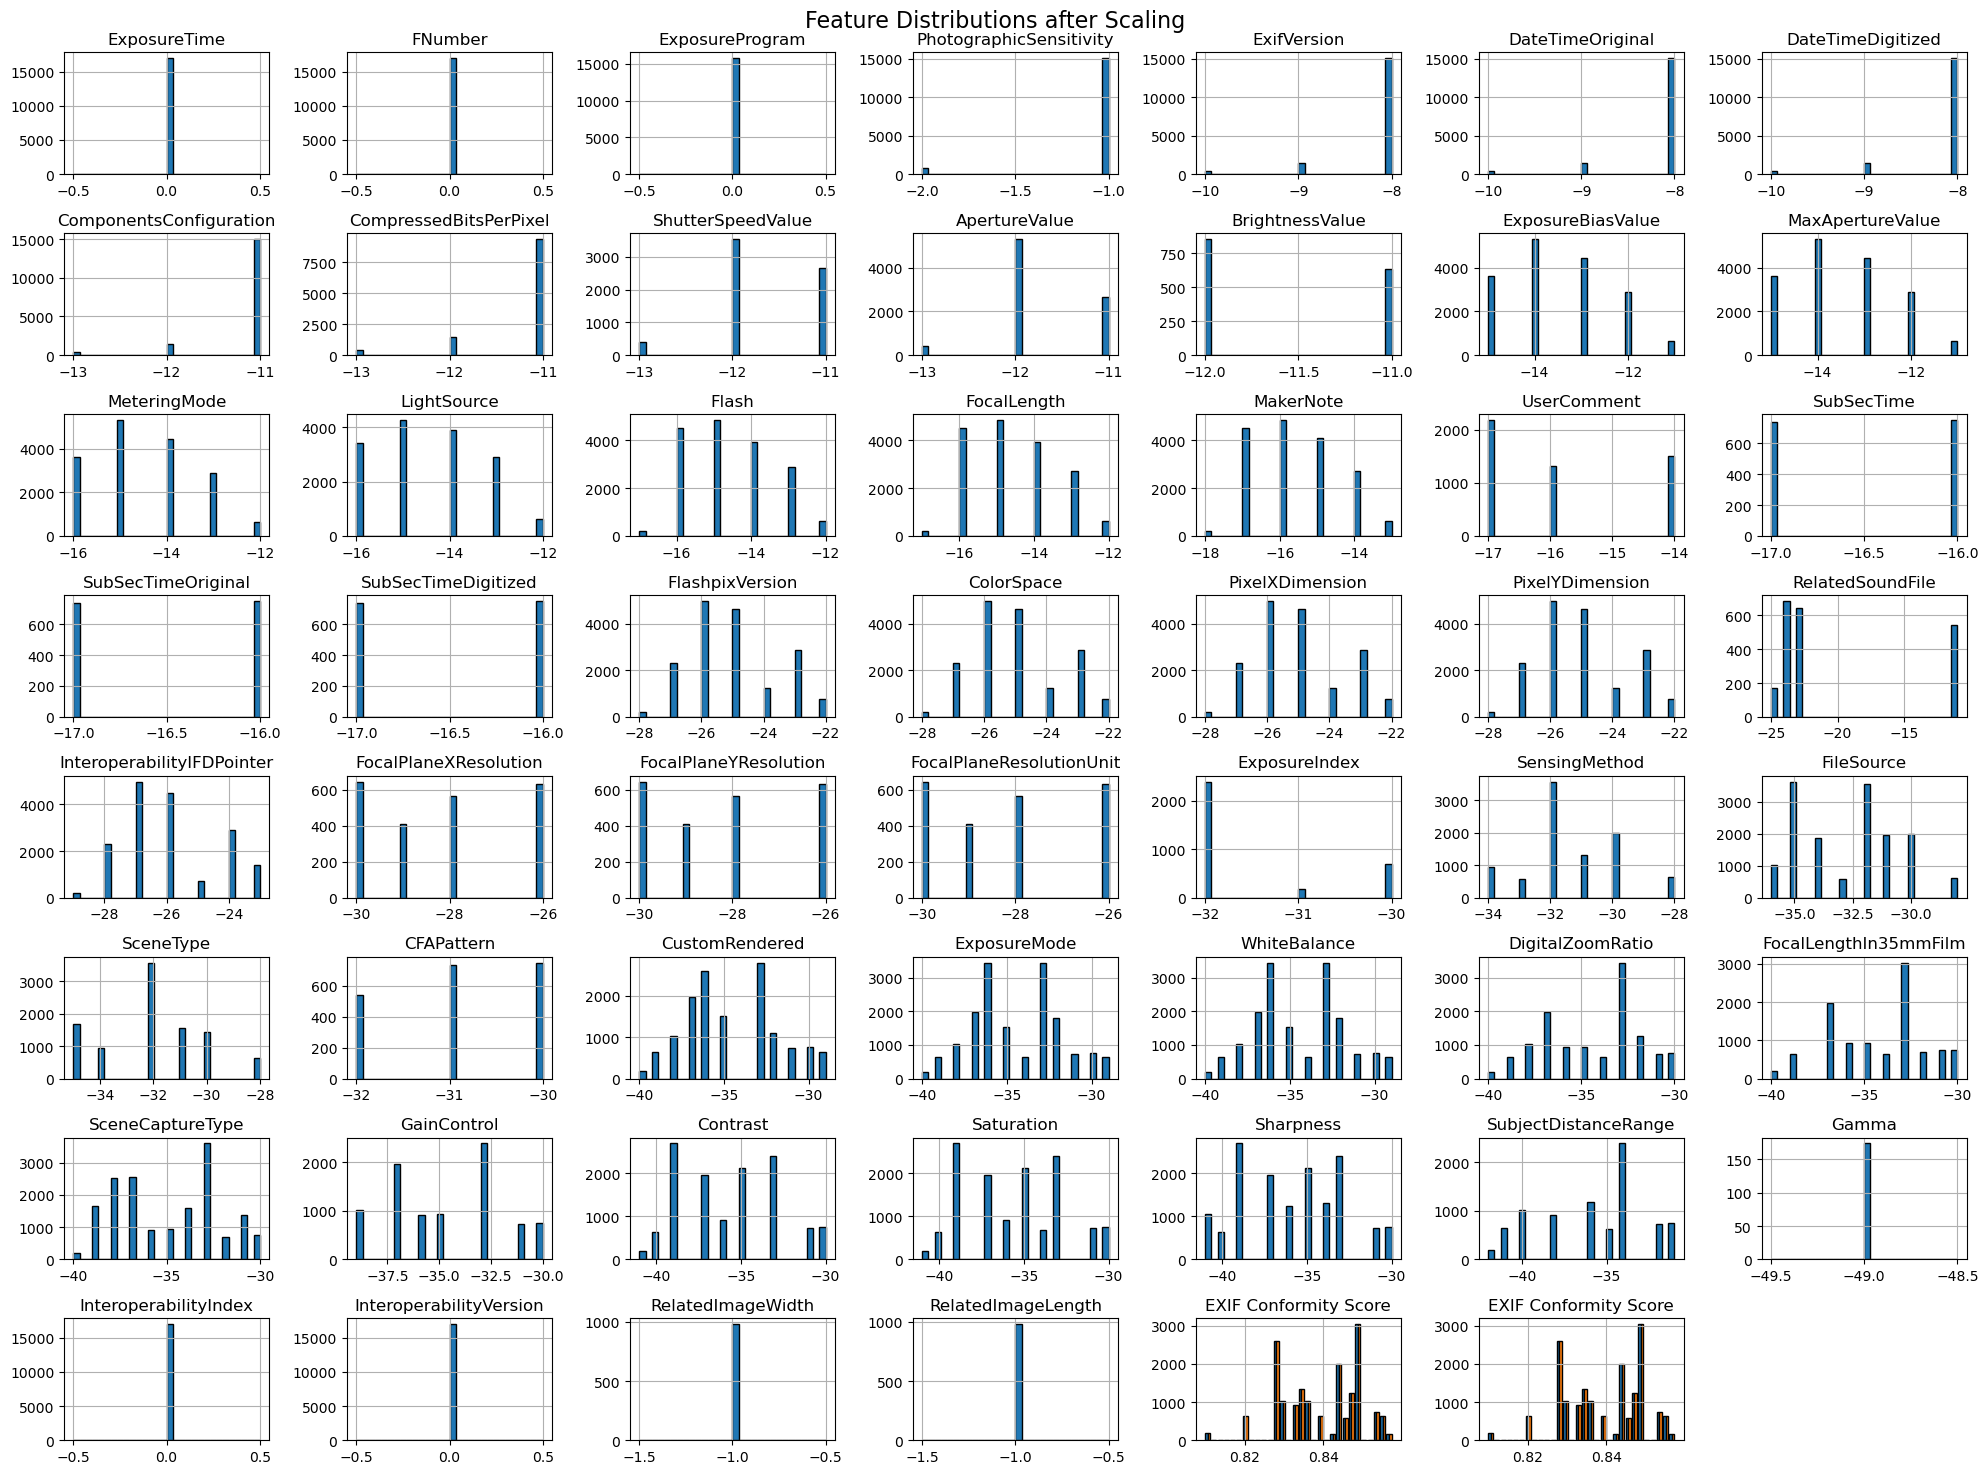

In [48]:
non_nan_df_dresden = visuals_df_dresden.dropna(axis=1, how='all')
print(len(non_nan_df_dresden.columns))

non_nan_df_dresden.hist(bins=30, figsize=(20, 15), edgecolor='black')
plt.suptitle('Feature Distributions after Scaling', fontsize=16)
plt.tight_layout()
plt.show()

63


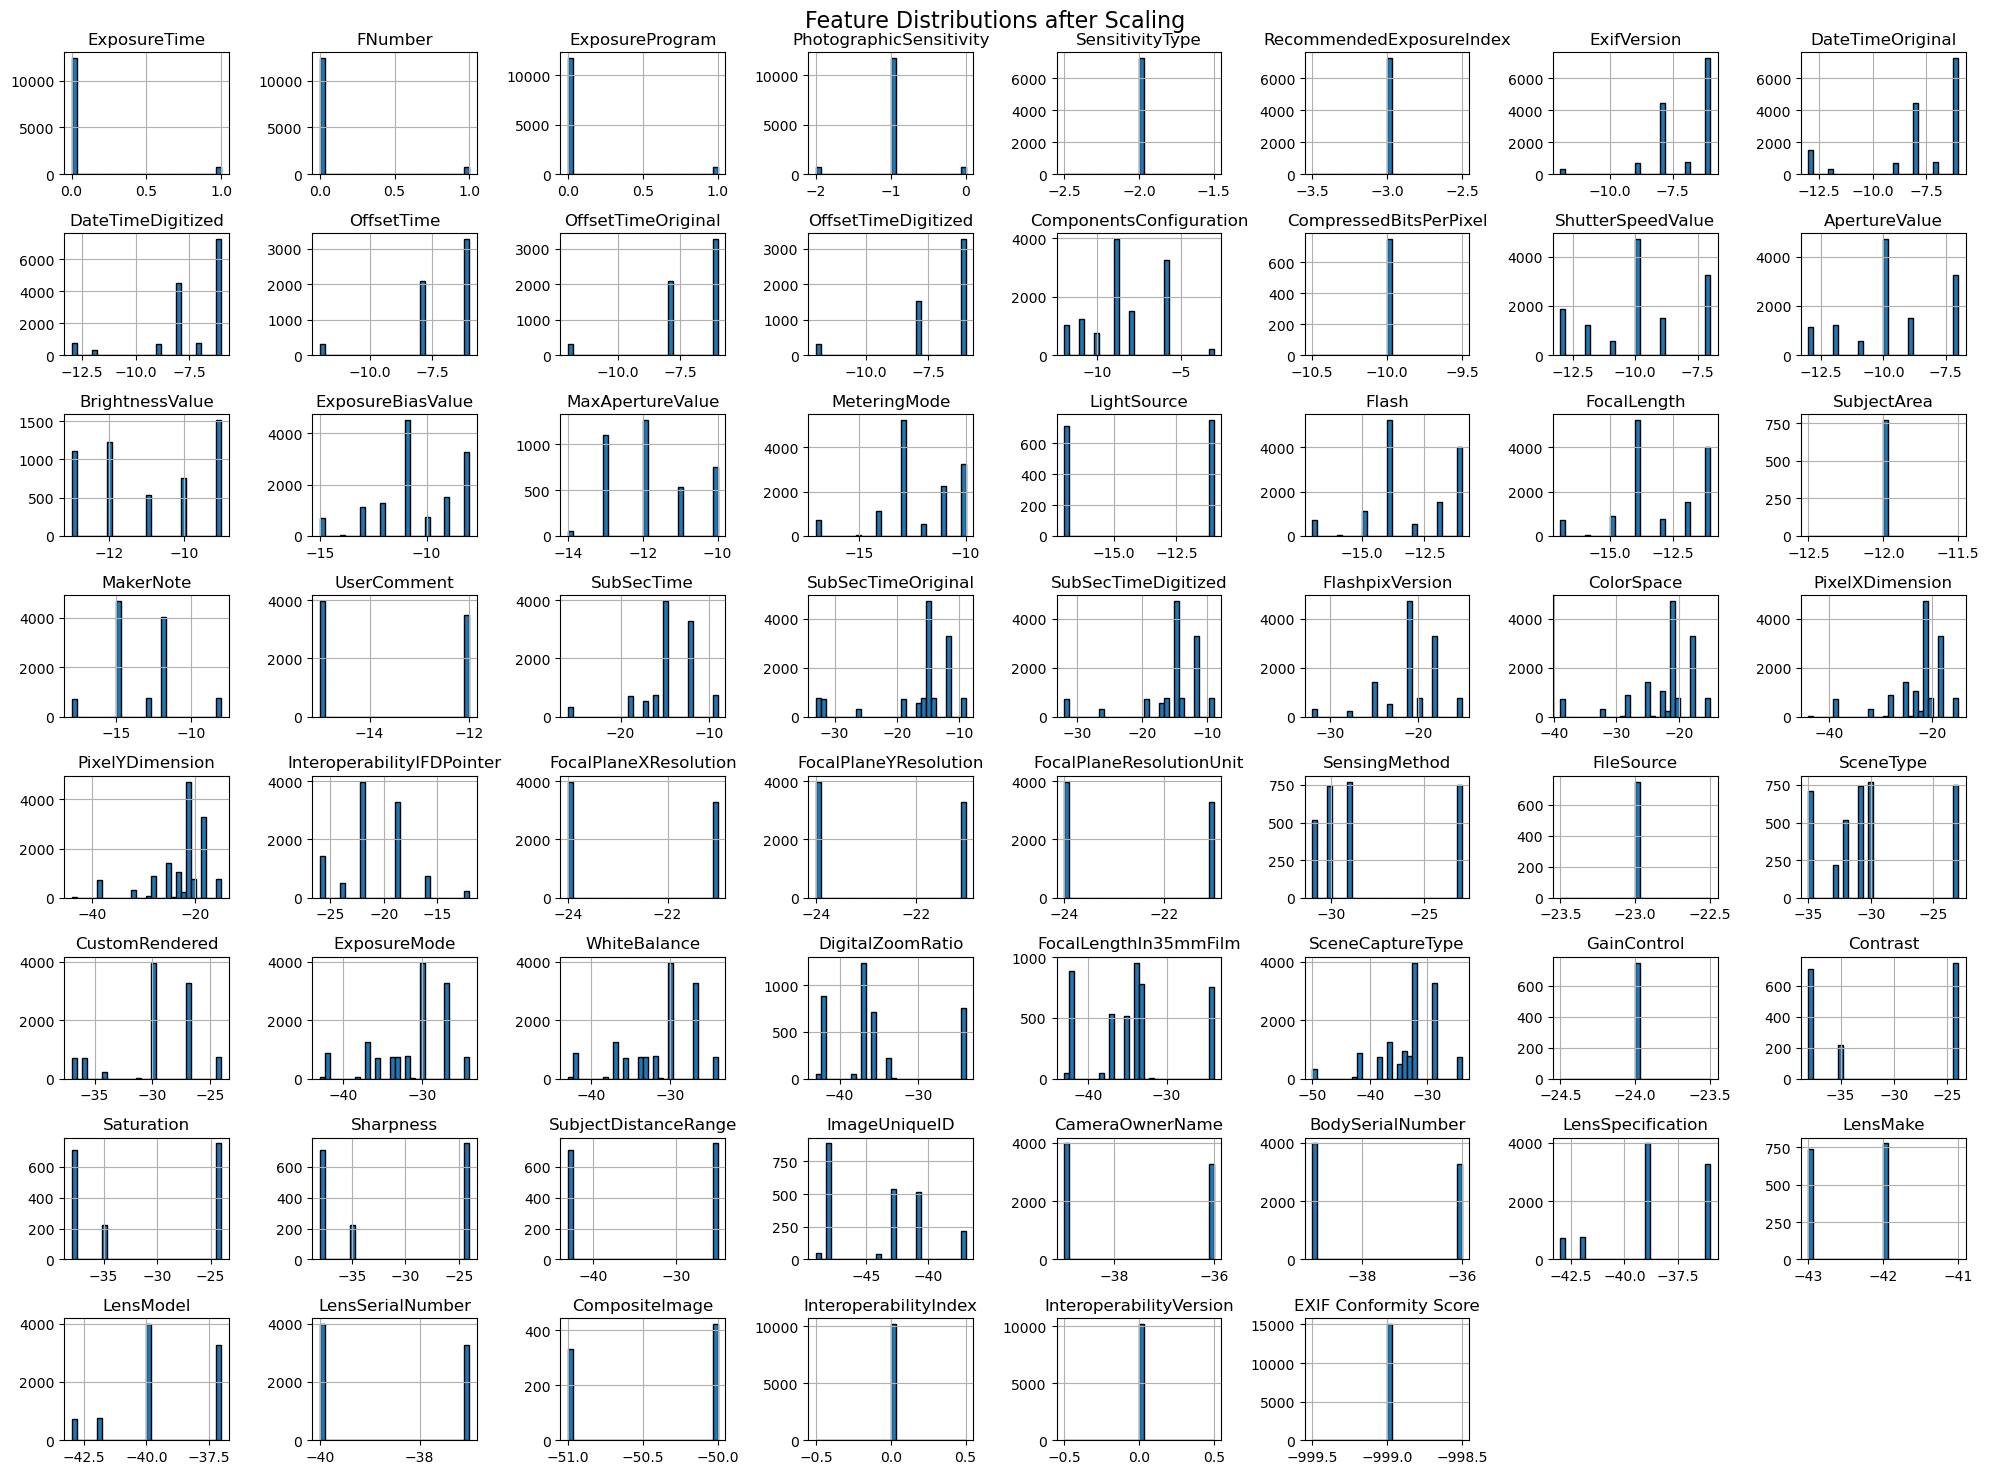

In [49]:
non_nan_df_divnoise = visuals_df_divnoise.dropna(axis=1, how='all')
print(len(non_nan_df_divnoise.columns))

non_nan_df_divnoise.hist(bins=30, figsize=(20, 15), edgecolor='black')
plt.suptitle('Feature Distributions after Scaling', fontsize=16)
plt.tight_layout()
plt.show()

In [50]:
# Total Non-nan counts

nan_counts = visuals_df_dresden.isna().sum().sum()
non_nan_counts = visuals_df_dresden.notna().sum().sum()


print(f"NaN values: {nan_counts}")
print(f"Non-NaN values: {non_nan_counts}")
print(f"Non-NaN percent: {round(non_nan_counts/(non_nan_counts+nan_counts) * 100, 5)}%")



NaN values: 1535718
Non-NaN values: 652251
Non-NaN percent: 29.8108%


In [51]:
# Total Non-nan counts

nan_counts = visuals_df_divnoise.isna().sum().sum()
non_nan_counts = visuals_df_divnoise.notna().sum().sum()


print(f"NaN values: {nan_counts}")
print(f"Non-NaN values: {non_nan_counts}")
print(f"Non-NaN percent: {round(non_nan_counts/(non_nan_counts+nan_counts) * 100, 5)}%")



NaN values: 1401444
Non-NaN values: 535749
Non-NaN percent: 27.65594%


In [52]:
print(visuals_df_divnoise.columns)

Index(['ExposureTime', 'FNumber', 'ExposureProgram', 'SpectralSensitivity',
       'PhotographicSensitivity', 'OECF', 'SensitivityType',
       'StandardOutputSensitivity', 'RecommendedExposureIndex', 'ISOSpeed',
       ...
       'GPSDifferential', 'GPSHPositioningError', 'InteroperabilityIndex',
       'InteroperabilityVersion', 'RelatedImageFileFormat',
       'RelatedImageWidth', 'RelatedImageLength', 'EXIF Conformity Score',
       'brand', 'EXIF Conformity Score'],
      dtype='object', length=129)


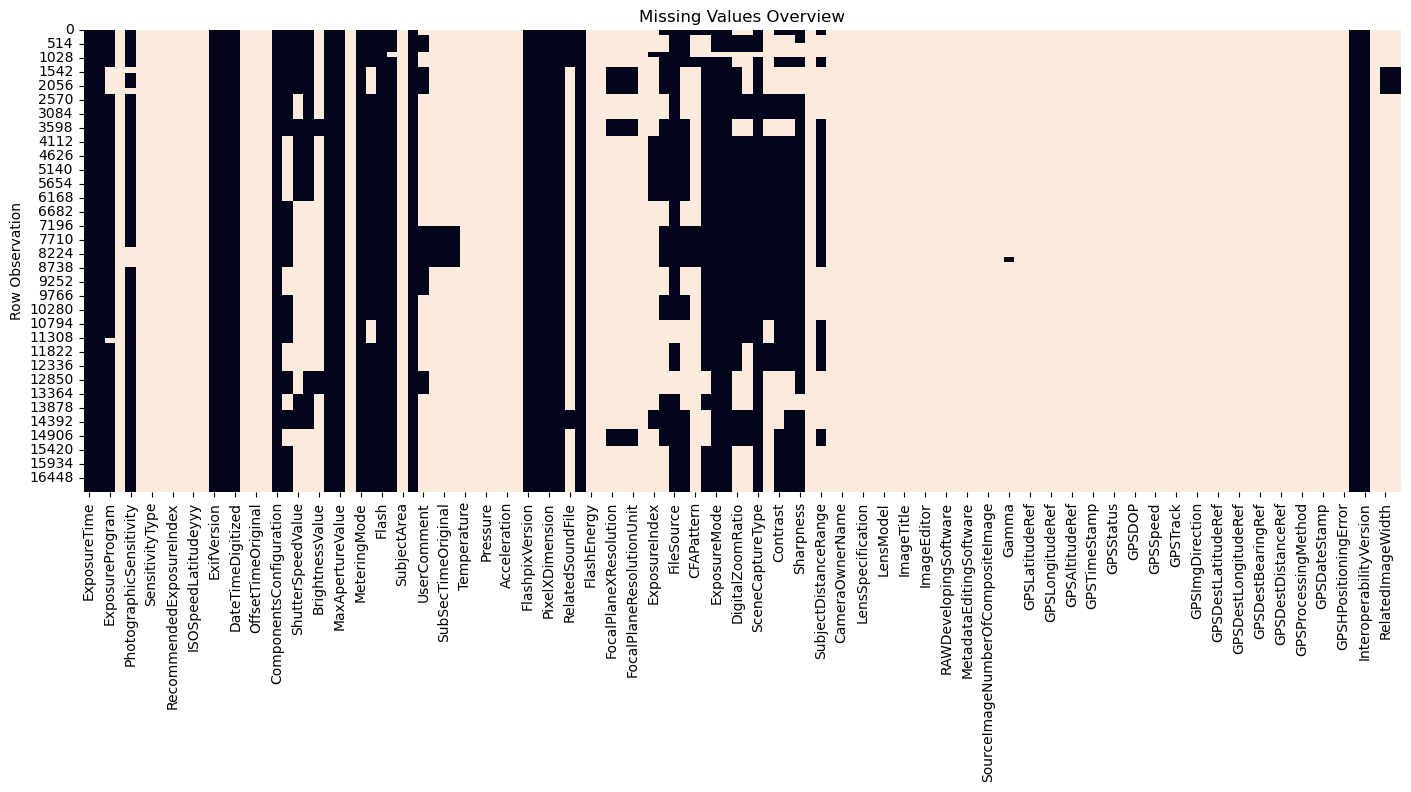

In [53]:

plt.figure(figsize=(17, 6))
sns.heatmap(visuals_df_dresden.drop(columns=["brand", "EXIF Conformity Score"]).isna(), cbar=False)
plt.title('Missing Values Overview')
plt.ylabel("Row Observation")
# plt.yticks(ticks=range(len(models)), labels=models, fontsize=6)
plt.yticks()

plt.show()



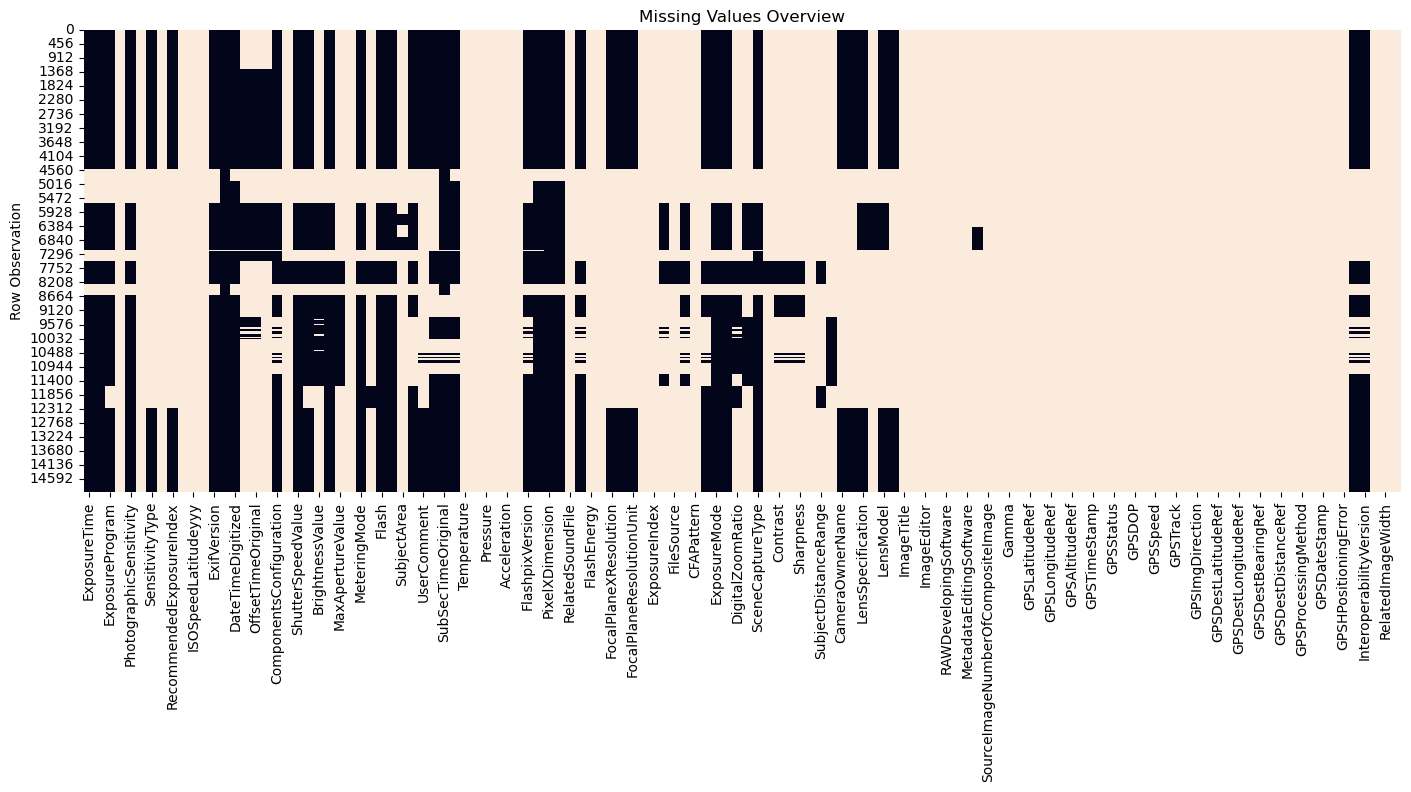

In [54]:

plt.figure(figsize=(17, 6))
sns.heatmap(visuals_df_divnoise.drop(columns=["brand", "EXIF Conformity Score"]).isna(), cbar=False)
plt.title('Missing Values Overview')
plt.ylabel("Row Observation")
# plt.yticks(ticks=range(len(models)), labels=models, fontsize=6)
plt.yticks()

plt.show()



In [55]:
# 1. Features present in ALL images (no NaNs at all)
features_in_all_images_dresden = visuals_df_dresden.columns[visuals_df_dresden.notnull().all()].tolist()

features_in_all_images_divnoise = visuals_df_divnoise.columns[visuals_df_divnoise.notnull().all()].tolist()


# 2. Features present in AT LEAST ONE image (not entirely NaN)
features_not_all_nan = visuals_df.columns[visuals_df.notnull().any()].tolist()

print("Features in ALL DRESDEN images:")
print(features_in_all_images_dresden)
print(f"Total: {len(features_in_all_images_dresden)}\n")

print("Features in ALL DIVNOISE images:")
print(features_in_all_images_divnoise)
print(f"Total: {len(features_in_all_images_divnoise)}\n")


print("\nFeatures present in AT LEAST ONE image in all images:")
print(features_not_all_nan)
print(f"\nTotal: {len(features_not_all_nan)}")


Features in ALL DRESDEN images:
['ExposureTime', 'FNumber', 'ExifVersion', 'DateTimeOriginal', 'DateTimeDigitized', 'ComponentsConfiguration', 'ExposureBiasValue', 'MaxApertureValue', 'MeteringMode', 'Flash', 'MakerNote', 'FlashpixVersion', 'ColorSpace', 'PixelXDimension', 'PixelYDimension', 'InteroperabilityIFDPointer', 'InteroperabilityIndex', 'InteroperabilityVersion', 'EXIF Conformity Score', 'brand', 'EXIF Conformity Score']
Total: 21

Features in ALL DIVNOISE images:
['brand', 'EXIF Conformity Score']
Total: 2


Features present in AT LEAST ONE image in all images:
['ExposureTime', 'FNumber', 'ExposureProgram', 'PhotographicSensitivity', 'SensitivityType', 'RecommendedExposureIndex', 'ExifVersion', 'DateTimeOriginal', 'DateTimeDigitized', 'OffsetTime', 'OffsetTimeOriginal', 'OffsetTimeDigitized', 'ComponentsConfiguration', 'CompressedBitsPerPixel', 'ShutterSpeedValue', 'ApertureValue', 'BrightnessValue', 'ExposureBiasValue', 'MaxApertureValue', 'MeteringMode', 'LightSource', 'Fla

## Training on Features Only

## Train-Test Split

In [56]:
# Drop label columns from X
# X = X_reduced_df.drop(columns=["EXIF Conformity Score"]
dresden_split = len(dresden_data)
training_features_dresden = training_features[:dresden_split]
training_features_divnoise = training_features[dresden_split:]

# Labels
test_labels_dresden = test_labels.iloc[:dresden_split].reset_index(drop=True)
test_labels_divnoise = test_labels.iloc[dresden_split:].reset_index(drop=True)

# Targets
y_model_dresden = test_labels_dresden["model"]
y_brand_dresden = test_labels_dresden["brand"]

# Split Dresden for evaluation
X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(
    training_features_dresden, y_model_dresden, test_size=0.2, random_state=42, stratify=y_model_dresden
)

X_train_brand, X_test_brand, y_train_brand, y_test_brand = train_test_split(
    training_features_dresden, y_brand_dresden, test_size=0.2, random_state=42, stratify=y_brand_dresden
)

print("Train shape (model-level):", X_train_model.shape)
print("Test shape (model-level):", X_test_model.shape)


Train shape (model-level): (13568, 128)
Test shape (model-level): (3393, 128)


## Random Forest Decision Tree      

#### Brand Attribution (Indicates misclassification is limited to brand)

In [107]:
tree_model_alt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree_model_alt.fit(X_train_brand, y_train_brand)

# Predict
y_pred_tree = tree_model_alt.predict(X_test_brand)

# Metrics
print("Decision Tree Results:")
print(classification_report(y_test_brand, y_pred_tree))
print(f"Accuracy: {accuracy_score(y_test_brand, y_pred_tree):.4f}")


Decision Tree Results:
              precision    recall  f1-score   support

        Agfa       1.00      1.00      1.00       272
       Canon       1.00      1.00      1.00       196
       Casio       1.00      1.00      1.00       185
    FujiFilm       1.00      1.00      1.00       126
       Kodak       1.00      1.00      1.00       478
       Nikon       1.00      1.00      1.00       483
     Olympus       1.00      1.00      1.00       208
   Panasonic       1.00      1.00      1.00       186
      Pentax       1.00      1.00      1.00       166
    Praktica       1.00      1.00      1.00       204
       Ricoh       1.00      1.00      1.00       171
      Rollei       1.00      1.00      1.00       118
     Samsung       1.00      1.00      1.00       266
        Sony       1.00      1.00      1.00       334

    accuracy                           1.00      3393
   macro avg       1.00      1.00      1.00      3393
weighted avg       1.00      1.00      1.00      3393

Ac

## Device Attribution

#### Simple Decision Tree

In [395]:

tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree_model.fit(X_train_model, y_train_model)

# Predict
y_pred_tree = tree_model.predict(X_test_model)

# Metrics
print("Decision Tree Results:")
print(classification_report(y_test_model, y_pred_tree))
print(f"Accuracy: {accuracy_score(y_test_model, y_pred_tree):.4f}")
print(f"Precision: {precision_score(y_test_model, y_pred_tree, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_model, y_pred_tree, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_model, y_pred_tree, average='weighted'):.4f}")


Decision Tree Results:
                     precision    recall  f1-score   support

        Agfa_DC-504       0.31      1.00      0.48        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.00      0.00      0.00        74
       Canon_Ixus55       0.00      0.00      0.00        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.46      1.00      0.63        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      1.00      1.00       147
 Olympus_mju_1050SW       1.00      1.00      1.00       208


c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packag

#### Exhaustive Random Forest

In [396]:

# Define hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Set up and run grid search
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='accuracy', verbose=2)
grid_search.fit(X_train_model, y_train_model)

# Use best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_model)

# Print best params and scores
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)
print("\nEvaluation on Test Set:")
print(classification_report(y_test_model, y_pred_best))
print(f"Accuracy:  {accuracy_score(y_test_model, y_pred_best):.4f}")
print(f"Precision: {precision_score(y_test_model, y_pred_best, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test_model, y_pred_best, average='weighted', zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test_model, y_pred_best, average='weighted', zero_division=0):.4f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.9208431197696834

Evaluation on Test Set:
                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.00      0.00      0.00        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.46      1.00      0.63        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nik

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.8818
Recall:    0.9187
F1 Score:  0.8936


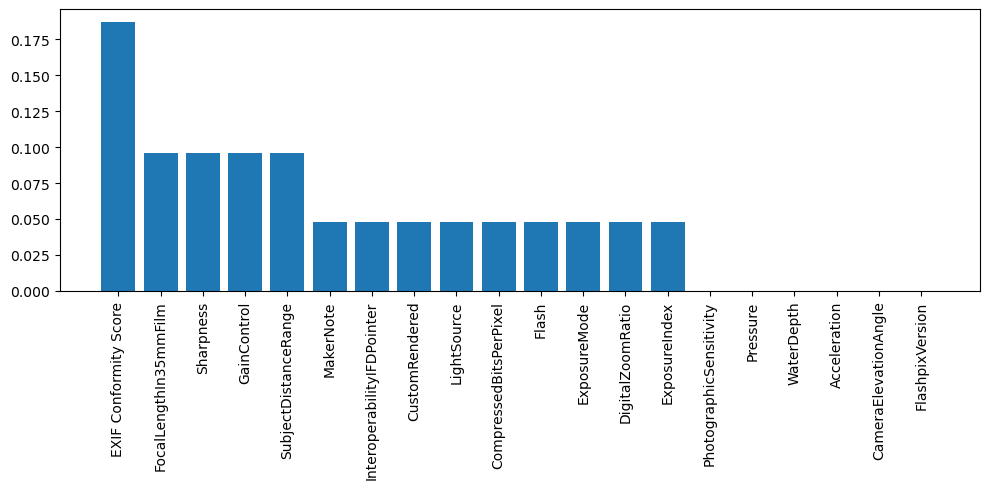

In [397]:
importances = tree_model.feature_importances_

# Sort
indices = importances.argsort()[::-1]

feature_names = X_train_model.columns

# Plot
plt.figure(figsize=(10,5))
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

### K-Nearest Neighbour

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

k_values = [3, 5, 7, 9, 11]
metrics = ['euclidean', 'manhattan']

def evaluate_knn(X_train, X_test, y_train, y_test, title="Model Attribution"):
    results = []

    for metric in metrics:
        for k in k_values:
            model = KNeighborsClassifier(n_neighbors=k, metric=metric, n_jobs=-1)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)

            acc = accuracy_score(y_test, preds)
            f1 = f1_score(y_test, preds, average='macro')

            results.append((k, metric, acc, f1))
            print(f"{title} | K={k}, Metric={metric} | Accuracy={acc:.3f}, Macro F1={f1:.3f}")

    fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    for idx, metric in enumerate(metrics):
        accs = [r[2] for r in results if r[1] == metric]
        f1s = [r[3] for r in results if r[1] == metric]
        ax[idx].plot(k_values, accs, label='Accuracy', marker='o')
        ax[idx].plot(k_values, f1s, label='Macro F1', marker='s')
        ax[idx].set_title(f"{title} ({metric})")
        ax[idx].set_xlabel("k")
        ax[idx].set_ylabel("Score")
        ax[idx].legend()
        ax[idx].grid(True)

    plt.tight_layout()
    plt.show()




Model Attribution | K=3, Metric=euclidean | Accuracy=0.822, Macro F1=0.674
Model Attribution | K=5, Metric=euclidean | Accuracy=0.822, Macro F1=0.674
Model Attribution | K=7, Metric=euclidean | Accuracy=0.822, Macro F1=0.675
Model Attribution | K=9, Metric=euclidean | Accuracy=0.822, Macro F1=0.675
Model Attribution | K=11, Metric=euclidean | Accuracy=0.832, Macro F1=0.679
Model Attribution | K=3, Metric=manhattan | Accuracy=0.822, Macro F1=0.674
Model Attribution | K=5, Metric=manhattan | Accuracy=0.822, Macro F1=0.674
Model Attribution | K=7, Metric=manhattan | Accuracy=0.822, Macro F1=0.675
Model Attribution | K=9, Metric=manhattan | Accuracy=0.822, Macro F1=0.675
Model Attribution | K=11, Metric=manhattan | Accuracy=0.832, Macro F1=0.679


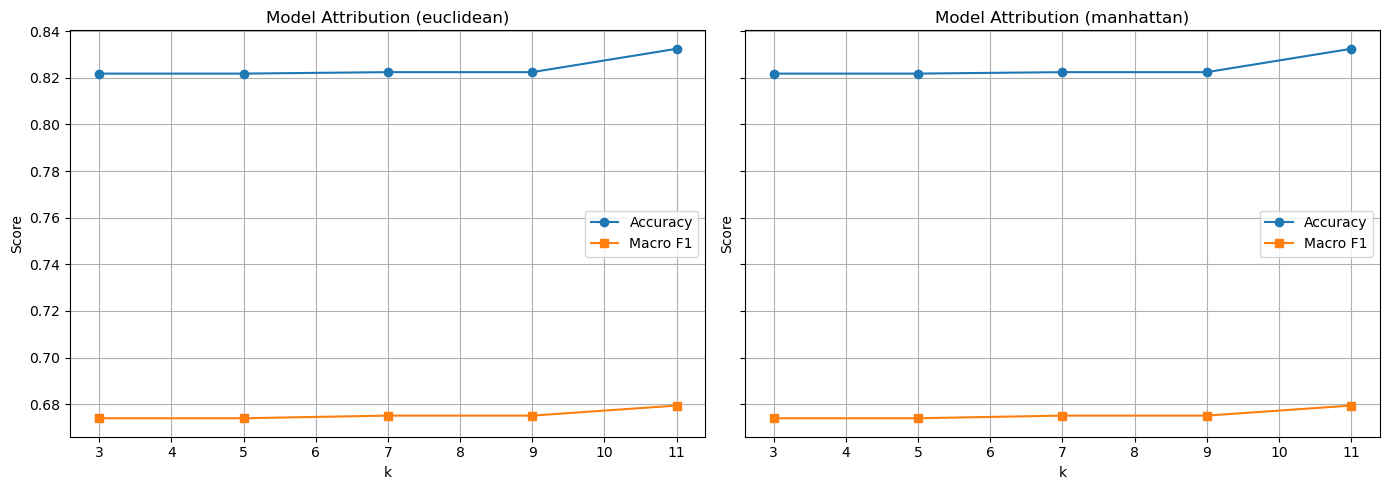

Brand Attribution | K=3, Metric=euclidean | Accuracy=0.988, Macro F1=0.930
Brand Attribution | K=5, Metric=euclidean | Accuracy=0.988, Macro F1=0.930
Brand Attribution | K=7, Metric=euclidean | Accuracy=0.988, Macro F1=0.930
Brand Attribution | K=9, Metric=euclidean | Accuracy=0.988, Macro F1=0.930
Brand Attribution | K=11, Metric=euclidean | Accuracy=0.988, Macro F1=0.930
Brand Attribution | K=3, Metric=manhattan | Accuracy=0.988, Macro F1=0.930
Brand Attribution | K=5, Metric=manhattan | Accuracy=0.988, Macro F1=0.930
Brand Attribution | K=7, Metric=manhattan | Accuracy=0.988, Macro F1=0.930
Brand Attribution | K=9, Metric=manhattan | Accuracy=0.988, Macro F1=0.930
Brand Attribution | K=11, Metric=manhattan | Accuracy=0.988, Macro F1=0.930


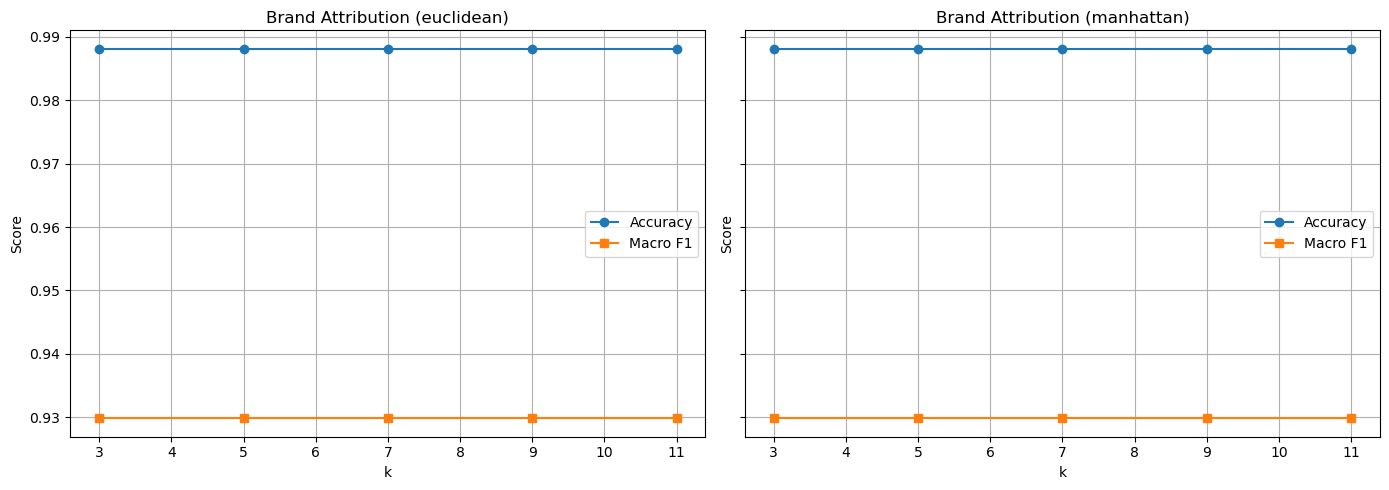

In [387]:
# Evaluate KNN for model-level prediction
evaluate_knn(X_train_model, X_test_model, y_train_model, y_test_model, title="Model Attribution")

# Evaluate KNN for brand-level prediction
evaluate_knn(X_train_brand, X_test_brand, y_train_brand, y_test_brand, title="Brand Attribution")

# Training ECS Metric Only

### Train-Test Split

In [404]:
X_ecs = training_features_dresden[["EXIF Conformity Score"]]
y_ecs = test_labels_dresden["model"]

# Train/test split
X_train_ecs, X_test_ecs, y_train_ecs, y_test_ecs = train_test_split(
    X_ecs, y_ecs, test_size=0.2, random_state=42, stratify=y_ecs
)

### Decision Tree

In [405]:

# Train a simple decision tree
clf_ecs = DecisionTreeClassifier(class_weight='balanced', random_state=42)
clf_ecs.fit(X_train_ecs, y_train_ecs)

# Predict and evaluate
y_pred_ecs = clf_ecs.predict(X_test_ecs)

print("ECS-only Model Performance")
print(classification_report(y_test_ecs, y_pred_ecs))
print(f"Accuracy: {accuracy_score(y_test_ecs, y_pred_ecs):.4f}")


ECS-only Model Performance
                     precision    recall  f1-score   support

        Agfa_DC-504       0.31      1.00      0.48        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.00      0.00      0.00        74
       Canon_Ixus55       0.00      0.00      0.00        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.46      1.00      0.63        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      1.00      1.00       147
 Olympus_mju_1050SW       1.00      1.00      1.00       

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [406]:
knn_model = KNeighborsClassifier(n_neighbors=5)  # 5 neighbors, you can tweak this later
knn_model.fit(X_train_ecs, y_train_ecs)

# Predict
y_pred_knn = knn_model.predict(X_test_ecs)

# Metrics
print("\nKNN Results:")
print(classification_report(y_test_ecs, y_pred_knn))
print(f"Accuracy: {accuracy_score(y_test_ecs, y_pred_knn):.4f}")





KNN Results:
                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.54      1.00      0.70        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.00      0.00      0.00        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      1.00      1.00       147
 Olympus_mju_1050SW       1.00      1.00      1.00       208
 Panasoni

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Training on Both Features

In [408]:
X_full = training_features_dresden
y_full = test_labels_dresden["model"]

# Split
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

In [417]:
clf_full = DecisionTreeClassifier(random_state=42)
clf_full.fit(X_train_full, y_train_full)


y_pred_full = clf_full.predict(X_test_full)

print("Full Feature Model Performance")
print(classification_report(y_test_full, y_pred_full))
print(f"Accuracy: {accuracy_score(y_test_full, y_pred_full):.4f}")
print(f"Precision: {precision_score(y_test_full, y_pred_full, average='weighted', zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test_full, y_pred_full, average='weighted', zero_division=0):.4f}")
print(f"F1 Score:  {f1_score(y_test_full, y_pred_full, average='weighted', zero_division=0):.4f}")


Full Feature Model Performance
                     precision    recall  f1-score   support

        Agfa_DC-504       0.00      0.00      0.00        34
       Agfa_DC-733s       0.88      1.00      0.93        56
       Agfa_DC-830i       1.00      0.89      0.94        73
   Agfa_Sensor505-x       1.00      1.00      1.00        34
    Agfa_Sensor530s       0.69      1.00      0.81        74
       Canon_Ixus55       0.54      1.00      0.70        45
       Canon_Ixus70       1.00      1.00      1.00       113
Canon_PowerShotA640       0.00      0.00      0.00        38
      Casio_EX-Z150       1.00      1.00      1.00       185
FujiFilm_FinePixJ50       1.00      1.00      1.00       126
        Kodak_M1063       1.00      1.00      1.00       478
  Nikon_CoolPixS710       1.00      1.00      1.00       185
         Nikon_D200       1.00      1.00      1.00       151
          Nikon_D70       1.00      1.00      1.00       147
 Olympus_mju_1050SW       1.00      1.00      1.00   

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.8839
Recall:    0.9207
F1 Score:  0.8959


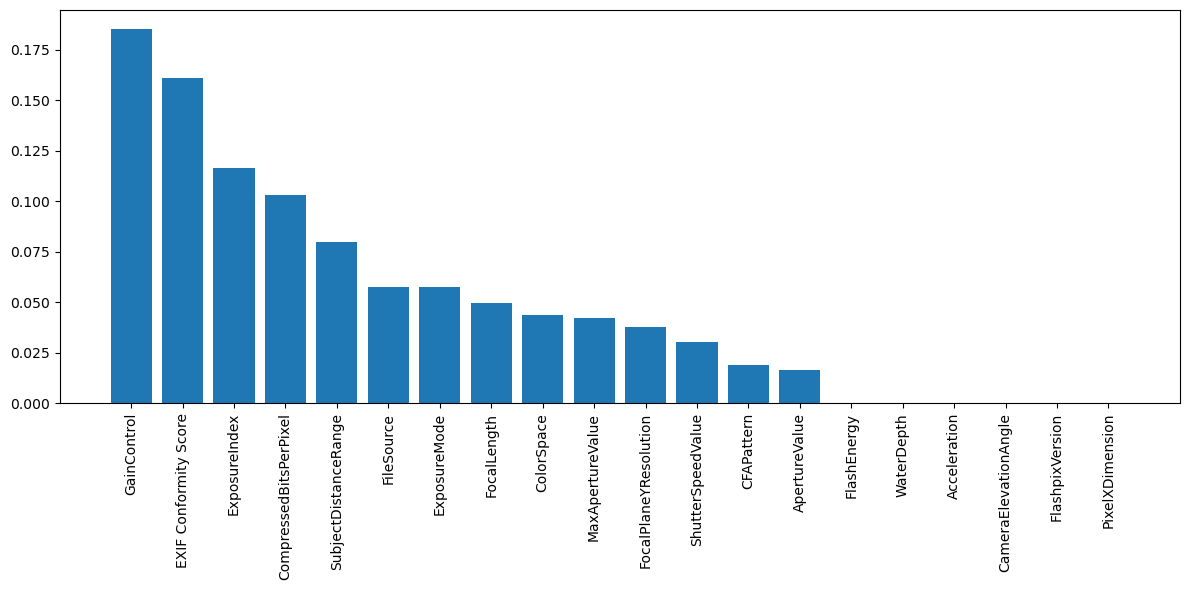

In [418]:
importances = clf_full.feature_importances_

# Sort
indices = importances.argsort()[::-1]
feature_names = X_train_full.columns

# Plot
plt.figure(figsize=(12,6))
plt.bar(range(20), importances[indices][:20], align='center')
plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

# What happens when we introduce DivNoise?

In [420]:

# Targets
y_model = test_labels["model"]
y_brand = test_labels["brand"]

# Split Dresden for evaluation
X_train_model, X_test_model, y_train_model, y_test_model = train_test_split(
    training_features, y_model, test_size=0.2, random_state=42, stratify=y_model
)

X_train_brand, X_test_brand, y_train_brand, y_test_brand = train_test_split(
    training_features, y_brand, test_size=0.2, random_state=42, stratify=y_brand
)

print("Train shape (model-level):", X_train_model.shape)
print("Test shape (model-level):", X_test_model.shape)


Train shape (model-level): (25582, 127)
Test shape (model-level): (6396, 127)


### Brand Attribution on DivNoise+Dresden

In [421]:
tree_model_alt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree_model_alt.fit(X_train_brand, y_train_brand)

# Predict
y_pred_tree = tree_model_alt.predict(X_test_brand)

# Metrics
print("Decision Tree Results:")
print(classification_report(y_test_brand, y_pred_tree))
print(f"Accuracy: {accuracy_score(y_test_brand, y_pred_tree):.4f}")


Decision Tree Results:
              precision    recall  f1-score   support

        Acer       0.50      1.00      0.67        76
        Agfa       1.00      1.00      1.00       271
       Apple       1.00      1.00      1.00       518
       Canon       1.00      1.00      1.00      1646
       Casio       1.00      1.00      1.00       185
    FujiFilm       1.00      1.00      1.00       126
      Huawei       1.00      1.00      1.00       150
       Kodak       1.00      1.00      1.00       478
    Logitech       0.00      0.00      0.00        76
    Motorola       1.00      1.00      1.00       142
       Nikon       1.00      1.00      1.00       483
     Olympus       1.00      1.00      1.00       208
   Panasonic       1.00      1.00      1.00       186
      Pentax       1.00      1.00      1.00       166
    Praktica       1.00      1.00      1.00       204
       Ricoh       1.00      1.00      1.00       171
      Rollei       1.00      1.00      1.00       118
    

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Device Attribution on DivNoise+Dresden

In [422]:

tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
tree_model.fit(X_train_model, y_train_model)

# Predict
y_pred_tree = tree_model.predict(X_test_model)

# Metrics
print("Decision Tree Results:")
print(classification_report(y_test_model, y_pred_tree))
print(f"Accuracy: {accuracy_score(y_test_model, y_pred_tree):.4f}")
print(f"Precision: {precision_score(y_test_model, y_pred_tree, average='weighted'):.4f}")
print(f"Recall:    {recall_score(y_test_model, y_pred_tree, average='weighted'):.4f}")
print(f"F1 Score:  {f1_score(y_test_model, y_pred_tree, average='weighted'):.4f}")


Decision Tree Results:
                              precision    recall  f1-score   support

       Acer_AspireE5_Frontal       0.00      0.00      0.00        76
                 Agfa_DC-504       0.00      0.00      0.00        34
                Agfa_DC-733s       0.93      1.00      0.97        56
                Agfa_DC-830i       1.00      0.95      0.97        73
            Agfa_Sensor505-x       1.00      1.00      1.00        34
             Agfa_Sensor530s       0.69      1.00      0.81        74
Apple_MacBookAir2018_Frontal       1.00      1.00      1.00        71
Apple_iMac27inch2012_Frontal       0.00      0.00      0.00        74
Apple_iMac27inch2013_Frontal       0.49      1.00      0.66        71
     Apple_iPadmini5_Frontal       0.86      1.00      0.92        71
        Apple_iPadmini5_Rear       1.00      1.00      1.00        71
      Apple_iPhone13_Frontal       1.00      0.84      0.92        77
         Apple_iPhone13_Rear       1.00      1.00      1.00       

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packag

Precision: 0.7077
Recall:    0.7850
F1 Score:  0.7254


# Revised Feature Engiene - Improving features

### Now that we now the most important tags, we'll narrow features down, focusing on binary presence, offsets on present tags, removing features with insignificant variance

In [68]:
if "image" not in final_df.columns:
    final_df = final_df.merge(reference_df, on="id", how="left")



In [70]:
final_df.head()

id       device  ExposureTime  FNumber  ExposureProgram  \
0   0  Agfa_DC-504           0.0      0.0              0.0   
1   1  Agfa_DC-504           0.0      0.0              0.0   
2   2  Agfa_DC-504           0.0      0.0              0.0   
3   3  Agfa_DC-504           0.0      0.0              0.0   
4   4  Agfa_DC-504           0.0      0.0              0.0   

   SpectralSensitivity  PhotographicSensitivity  OECF  SensitivityType  \
0                  NaN                     -1.0   NaN              NaN   
1                  NaN                     -1.0   NaN              NaN   
2                  NaN                     -1.0   NaN              NaN   
3                  NaN                     -1.0   NaN              NaN   
4                  NaN                     -1.0   NaN              NaN   

   StandardOutputSensitivity  ...  GPSHPositioningError  \
0                        NaN  ...                   NaN   
1                        NaN  ...                   NaN   
2                        NaN  ...                   NaN   
3                        NaN  ...                   NaN   
4                        NaN  ...                   NaN   

   InteroperabilityIndex  InteroperabilityVersion  RelatedImageFileFormat  \
0                    0.0                      0.0                     NaN   
1                    0.0                      0.0                     NaN   
2                    0.0                      0.0                     NaN   
3                    0.0                      0.0                     NaN   
4                    0.0                      0.0                     NaN   

   RelatedImageWidth  RelatedImageLength  EXIF Conformity Score  brand  \
0                NaN                 NaN                0.84675   Agfa   
1                NaN                 NaN                0.84675   Agfa   
2                NaN                 NaN                0.84675   Agfa   
3                NaN                 NaN                0.84675   Agfa   
4                NaN                 NaN                0.84675   Agfa   

         model                 image  
0  Agfa_DC-504   Agfa_DC-504_0_1.JPG  
1  Agfa_DC-504  Agfa_DC-504_0_10.JPG  
2  Agfa_DC-504  Agfa_DC-504_0_11.JPG  
3  Agfa_DC-504  Agfa_DC-504_0_12.JPG  
4  Agfa_DC-504  Agfa_DC-504_0_13.JPG  

[5 rows x 132 columns]

In [71]:
final_df = final_df.merge(unknown_df_cleaned, on="image", how="left")
final_df

id                  device  ExposureTime  FNumber  ExposureProgram  \
0          0             Agfa_DC-504           0.0      0.0              0.0   
1          1             Agfa_DC-504           0.0      0.0              0.0   
2          2             Agfa_DC-504           0.0      0.0              0.0   
3          3             Agfa_DC-504           0.0      0.0              0.0   
4          4             Agfa_DC-504           0.0      0.0              0.0   
...      ...                     ...           ...      ...              ...   
31973  31973  Canon_EOS6DMarkII_Rear           0.0      0.0              0.0   
31974  31974  Canon_EOS6DMarkII_Rear           0.0      0.0              0.0   
31975  31975  Canon_EOS6DMarkII_Rear           0.0      0.0              0.0   
31976  31976  Canon_EOS6DMarkII_Rear           0.0      0.0              0.0   
31977  31977  Canon_EOS6DMarkII_Rear           0.0      0.0              0.0   

       SpectralSensitivity  PhotographicSensitivity  OECF  SensitivityType  \
0                      NaN                     -1.0   NaN              NaN   
1                      NaN                     -1.0   NaN              NaN   
2                      NaN                     -1.0   NaN              NaN   
3                      NaN                     -1.0   NaN              NaN   
4                      NaN                     -1.0   NaN              NaN   
...                    ...                      ...   ...              ...   
31973                  NaN                     -1.0   NaN             -2.0   
31974                  NaN                     -1.0   NaN             -2.0   
31975                  NaN                     -1.0   NaN             -2.0   
31976                  NaN                     -1.0   NaN             -2.0   
31977                  NaN                     -1.0   NaN             -2.0   

       StandardOutputSensitivity  ...  EXIF Conformity Score  brand  \
0                            NaN  ...                0.84675   Agfa   
1                            NaN  ...                0.84675   Agfa   
2                            NaN  ...                0.84675   Agfa   
3                            NaN  ...                0.84675   Agfa   
4                            NaN  ...                0.84675   Agfa   
...                          ...  ...                    ...    ...   
31973                        NaN  ...                    NaN  Canon   
31974                        NaN  ...                    NaN  Canon   
31975                        NaN  ...                    NaN  Canon   
31976                        NaN  ...                    NaN  Canon   
31977                        NaN  ...                    NaN  Canon   

                        model                                image  \
0                 Agfa_DC-504                  Agfa_DC-504_0_1.JPG   
1                 Agfa_DC-504                 Agfa_DC-504_0_10.JPG   
2                 Agfa_DC-504                 Agfa_DC-504_0_11.JPG   
3                 Agfa_DC-504                 Agfa_DC-504_0_12.JPG   
4                 Agfa_DC-504                 Agfa_DC-504_0_13.JPG   
...                       ...                                  ...   
31973  Canon_EOS6DMarkII_Rear  Canon_EOS6DMarkII_Rear_6_Nat_95.jpg   
31974  Canon_EOS6DMarkII_Rear  Canon_EOS6DMarkII_Rear_6_Nat_96.jpg   
31975  Canon_EOS6DMarkII_Rear  Canon_EOS6DMarkII_Rear_6_Nat_97.jpg   
31976  Canon_EOS6DMarkII_Rear  Canon_EOS6DMarkII_Rear_6_Nat_98.jpg   
31977  Canon_EOS6DMarkII_Rear  Canon_EOS6DMarkII_Rear_6_Nat_99.jpg   

       UnknownTag_4746  UnknownTag_013c  UnknownTag_010d  UnknownTag_a40b  \
0                    0                0                0                0   
1                    0                0                0                0   
2                    0                0                0                0   
3                    0                0                0                0   
4                    0           

In [72]:
final_df.iloc[:, -6:].sum().sort_values(ascending=False)

UnknownTag_c4a5    5956
UnknownTag_4746    2391
UnknownTag_013c     802
UnknownTag_ea1c     759
UnknownTag_010d     751
UnknownTag_a40b     751
dtype: int64

In [73]:
final_df.iloc[:, -6:].apply(pd.Series.value_counts)

UnknownTag_4746  UnknownTag_013c  UnknownTag_010d  UnknownTag_a40b  \
0            29587            31176            31227            31227   
1             2391              802              751              751   

   UnknownTag_c4a5  UnknownTag_ea1c  
0            26022            31219  
1             5956              759

In [97]:
# Step 1: Remove metadata and ECS
raw_features = final_df.drop(columns=[
    "id", "device", "model", "brand", "EXIF Conformity Score"  # ← 'image' removed
])

# Step 2: Presence flags
presence_df = raw_features.notna().astype(int)
presence_df.columns = [f"has_{col}" for col in raw_features.columns]

# Step 3: Combine features
features_combined = pd.concat([raw_features.reset_index(drop=True), presence_df.reset_index(drop=True)], axis=1)

# Step 4: Reattach metadata
features_combined["model"] = final_df["model"].values
features_combined["brand"] = final_df["brand"].values
features_combined["id"] = final_df["id"].values


In [139]:
from collections import defaultdict
import json

def extract_absolute_offsets(combined_json):
    offsets_per_image = {}

    for image_path, image_data in combined_json.items():
        offsets = []

        app1_info = image_data.get("APP1 Info", {})
        for ifd_key in ["EXIF IFD Data", "GPS IFD Data", "Interop IFD Data"]:
            tag_dict = app1_info.get(ifd_key, {})
            for tag_name, tag_data in tag_dict.items():
                abs_offset = tag_data.get("Absolute Offset")
                if abs_offset is not None:
                    offsets.append(abs_offset)

        offsets_per_image[image_path] = sorted(offsets)

    return offsets_per_image

# Assuming you already have combined_json loaded in memory
offsets_dict = extract_absolute_offsets(combined_json)

# Save to a JSON file if you want
with open("absolute_offsets_per_image.json", "w", encoding="utf-8") as f:
    json.dump(offsets_dict, f, indent=2)


In [98]:
print(f"Original number of features (excluding metadata): {features_combined.shape[1] - 3}")

nan_counts = features_combined.isna().sum()
zero_var = features_combined.nunique()[features_combined.nunique() <= 1]

print(f"Total NaN-only features: {(nan_counts == len(features_combined)).sum()}")
print(f"Total zero-variance features: {len(zero_var)}")

print("\nFeatures with zero variance:")
print(zero_var.index.tolist())

print("\nFeatures with only NaNs:")
print(nan_counts[nan_counts == len(features_combined)].index.tolist())


Original number of features (excluding metadata): 266
Total NaN-only features: 59
Total zero-variance features: 133

Features with zero variance:
['SpectralSensitivity', 'OECF', 'SensitivityType', 'StandardOutputSensitivity', 'RecommendedExposureIndex', 'ISOSpeed', 'ISOSpeedLatitudeyyy', 'ISOSpeedLatitudezzz', 'SubjectDistance', 'SubjectArea', 'Temperature', 'Humidity', 'Pressure', 'WaterDepth', 'Acceleration', 'CameraElevationAngle', 'FlashEnergy', 'SpatialFrequencyResponse', 'SubjectLocation', 'DeviceSettingDescription', 'ImageTitle', 'Photographer', 'ImageEditor', 'CameraFirmware', 'RAWDevelopingSoftware', 'ImageEditingSoftware', 'MetadataEditingSoftware', 'SourceImageNumberOfCompositeImage', 'SourceExposureTimesOfCompositeImage', 'Gamma', 'GPSVersionID', 'GPSLatitudeRef', 'GPSLatitude', 'GPSLongitudeRef', 'GPSLongitude', 'GPSAltitudeRef', 'GPSAltitude', 'GPSTimeStamp', 'GPSSatellites', 'GPSStatus', 'GPSMeasureMode', 'GPSDOP', 'GPSSpeedRef', 'GPSSpeed', 'GPSTrackRef', 'GPSTrack', 'G

In [106]:
# --- Drop metadata and image path ---
X_cleaned = features_combined.drop(columns=["id", "model", "brand", "image"])  # ← fix is here

# --- Drop only all-NaN columns ---
X_cleaned = X_cleaned.dropna(axis=1, how="all")

# --- Separate columns to scale only raw features ---
raw_cols = [col for col in X_cleaned.columns if not col.startswith("has_")]
has_cols = [col for col in X_cleaned.columns if col.startswith("has_")]

# --- Scale only the raw features ---
scaler = StandardScaler()
X_scaled_raw = pd.DataFrame(scaler.fit_transform(X_cleaned[raw_cols].fillna(-999)), columns=raw_cols)

# --- Combine scaled + unscaled features ---
X_scaled = pd.concat([X_scaled_raw.reset_index(drop=True), X_cleaned[has_cols].reset_index(drop=True)], axis=1)

# --- Reattach metadata ---
X_scaled["model"] = features_combined["model"].values
X_scaled["brand"] = features_combined["brand"].values
X_scaled["id"] = features_combined["id"].values
X_scaled = X_scaled.drop(columns=["has_image"])


In [140]:
X_scaled


ExposureTime   FNumber  ExposureProgram  PhotographicSensitivity  \
0          0.246553  0.246553         0.362414                 0.320775   
1          0.246553  0.246553         0.362414                 0.320775   
2          0.246553  0.246553         0.362414                 0.320775   
3          0.246553  0.246553         0.362414                 0.320775   
4          0.246553  0.246553         0.362414                 0.320775   
...             ...       ...              ...                      ...   
31973      0.246553  0.246553         0.362414                 0.320775   
31974      0.246553  0.246553         0.362414                 0.320775   
31975      0.246553  0.246553         0.362414                 0.320775   
31976      0.246553  0.246553         0.362414                 0.320775   
31977      0.246553  0.246553         0.362414                 0.320775   

       SensitivityType  RecommendedExposureIndex  ExifVersion  \
0            -0.541470                 -0.541470     0.221299   
1            -0.541470                 -0.541470     0.221299   
2            -0.541470                 -0.541470     0.221299   
3            -0.541470                 -0.541470     0.221299   
4            -0.541470                 -0.541470     0.221299   
...                ...                       ...          ...   
31973         1.846824                  1.846824     0.230795   
31974         1.846824                  1.846824     0.230795   
31975         1.846824                  1.846824     0.230795   
31976         1.846824                  1.846824     0.230795   
31977         1.846824                  1.846824     0.230795   

       DateTimeOriginal  DateTimeDigitized  OffsetTime  ...  \
0              0.029680           0.158035   -0.464892  ...   
1              0.029680           0.158035   -0.464892  ...   
2              0.029680           0.158035   -0.464892  ...   
3              0.029680           0.158035   -0.464892  ...   
4              0.029680           0.158035   -0.464892  ...   
...                 ...                ...         ...  ...   
31973          0.090643           0.171002   -0.464892  ...   
31974          0.090643           0.171002   -0.464892  ...   
31975          0.090643           0.171002   -0.464892  ...   
31976          0.090643           0.171002   -0.464892  ...   
31977          0.090643           0.171002   -0.464892  ...   

       has_RelatedImageLength  has_UnknownTag_4746  has_UnknownTag_013c  \
0                           0                    1                    1   
1                           0                    1                    1   
2                           0                    1                    1   
3                           0                    1                    1   
4                           0                    1                    1   
...                       ...                  ...                  ...   
31973                       0                    1                    1   
31974                       0                    1                    1   
31975                       0                    1                    1   
31976                       0                    1                    1   
31977                       0                    1                    1   

       has_UnknownTag_010d  has_UnknownTag_a40b  has_UnknownTag_c4a5  \
0                        1                    1                    1   
1                        1                    1                    1   
2                        1                    1                    1   
3                        1                    1                    1   
4                        1                    1                    1   
...                    ...                  ...                  ...   
31973                    1                    1                    1   
31974                    1                    1                    1   
31975              

In [122]:
class_counts = X_scaled["model"].value_counts()
valid_classes = class_counts[class_counts >= 2].index
X_filtered = X_scaled[X_scaled["model"].isin(valid_classes)]

# Define features and labels
X_final = X_filtered.drop(columns=["model", "brand", "id"])
y_model = X_filtered["model"]
y_brand = X_filtered["brand"]


In [123]:
X_train, X_test, y_model_train, y_model_test, y_brand_train, y_brand_test = train_test_split(
    X_final, y_model, y_brand,
    test_size=0.2, random_state=42, stratify=y_model
)

In [131]:

class_counts = X_scaled["model"].value_counts()
valid_classes = class_counts[class_counts >= 2].index
X_filtered = X_scaled[X_scaled["model"].isin(valid_classes)]


# Setting labels properly
X_final = X_filtered.drop(columns=["model", "brand", "id"])
y_model = X_filtered["model"]
y_brand = X_filtered["brand"]


# Doing a split
X_train, X_test, y_model_train, y_model_test, y_brand_train, y_brand_test = train_test_split(
    X_final, y_model, y_brand,
    test_size=0.2, random_state=42, stratify=y_model
)



📊 Decision Tree Results (brand prediction):
              precision    recall  f1-score   support

        Acer       0.50      1.00      0.67        76
        Agfa       1.00      1.00      1.00       271
       Apple       1.00      1.00      1.00       518
       Canon       1.00      1.00      1.00      1647
       Casio       1.00      1.00      1.00       185
    FujiFilm       1.00      1.00      1.00       126
      Huawei       1.00      1.00      1.00       150
       Kodak       1.00      1.00      1.00       478
    Logitech       0.00      0.00      0.00        76
    Motorola       1.00      1.00      1.00       142
       Nikon       1.00      1.00      1.00       482
     Olympus       1.00      1.00      1.00       208
   Panasonic       1.00      1.00      1.00       186
      Pentax       1.00      1.00      1.00       166
    Praktica       1.00      1.00      1.00       204
       Ricoh       1.00      1.00      1.00       171
      Rollei       1.00      1.00    

c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saete\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


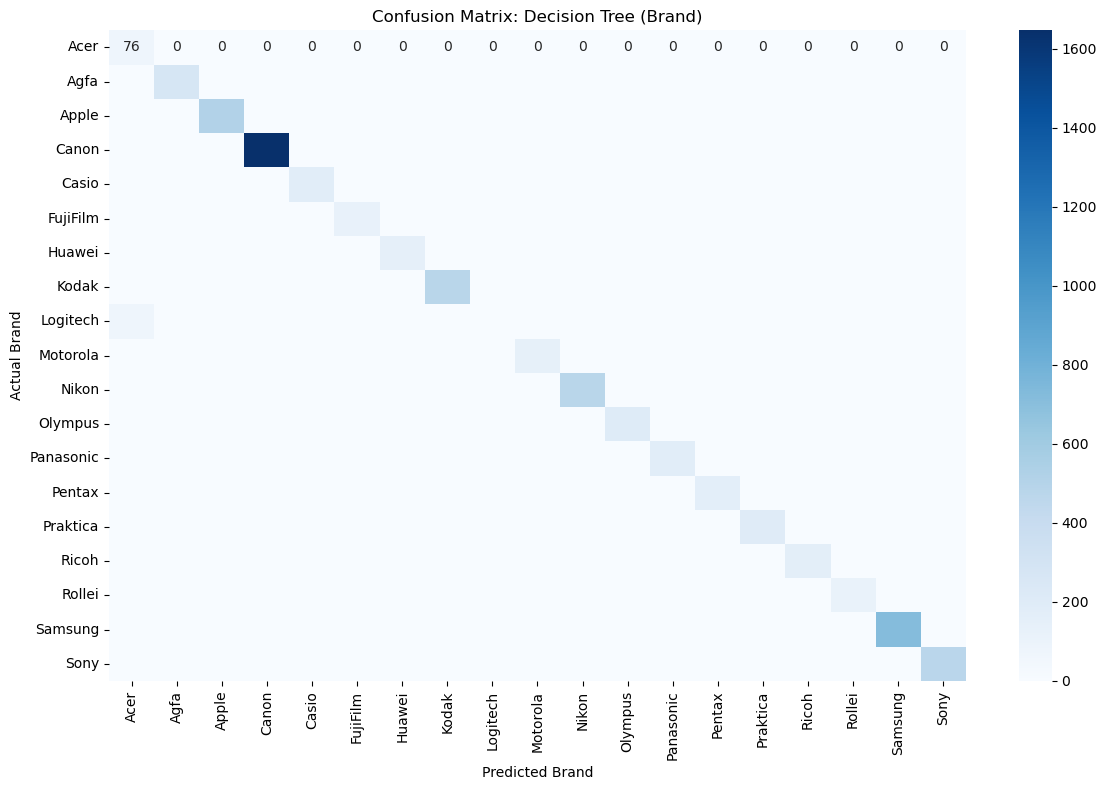

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Train the Decision Tree ---
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_brand_train)

# --- Step 2: Predict ---
y_pred = clf.predict(X_test)

# --- Step 3: Metrics ---
print("📊 Decision Tree Results (brand prediction):")
print(classification_report(y_brand_test, y_pred))
print(f"🔍 Accuracy: {accuracy_score(y_brand_test, y_pred):.4f}")

# --- Step 4: Confusion Matrix ---
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_brand_test, y_pred, labels=clf.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap="Blues")
plt.xlabel("Predicted Brand")
plt.ylabel("Actual Brand")
plt.title("Confusion Matrix: Decision Tree (Brand)")
plt.tight_layout()
plt.show()


### PCA Dimenionality Reduciton

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Ensure y is a pandas Series (e.g., model_device labels)
y_series = pd.Series(y_model).astype("category")
y_codes = y_series.cat.codes

# Run PCA on the full feature set
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_codes, cmap='tab20', alpha=0.6)
plt.title("PCA of EXIF-Based Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.colorbar(scatter, label="Device Code")
plt.tight_layout()
plt.show()

# Explained variance
print("Explained Variance Ratio (PCA components):", pca.explained_variance_ratio_)
